# Цель работы

Исследование влияния различных методов уменьшения размерности (PCA, Isomap, t-SNE, UMAP) на качество кластеризации, оцененное с помощью внутренних метрик (Silhouette Score, Calinski–Harabasz Index, Davies–Bouldin Index) и внешних метрик (при наличии разметки)



# Теоретическая часть
## Методы уменьшения размерности (Dimensionality Reduction - DR)
+ PCA (Principal Component Analysis):

   + Линейный метод, максимизирующий дисперсию данных

   + Сохраняет глобальную структуру данных

   + Вычислительно эффективен

+ Isomap (Isometric Mapping):

   + Нелинейный метод, сохраняющий геодезические расстояния

   + Основан на многомерном шкалировании (MDS)

   + Эффективен для данных с нелинейной структурой

+ t-SNE (t-distributed Stochastic Neighbor Embedding):

   + Вероятностный метод, сохраняющий локальную структуру

   + Эффективен для визуализации

   + Вычислительно сложен для больших данных

+ UMAP (Uniform Manifold Approximation and Projection):

   + Основан на теории топологических пространств

   + Сохражает как локальную, так и глобальную структуру

   + Вычислительно эффективнее t-SNE

## Метрики кластеризации
+ Внутренние метрики:
   + Silhouette Score: Мера компактности и разделимости кластеров

   + Calinski–Harabasz Index: Отношение дисперсии между кластерами к дисперсии внутри кластеров

   + Davies–Bouldin Index: Среднее сходство между кластерами

+ Внешние метрики:
   + Adjusted Rand Index (ARI)

   + Adjusted Mutual Information (AMI)

   + Homogeneity, Completeness, V-measure

# Задание 1: Подготовка данных и реализация DR-методов

In [2]:
# %pip install numpy pandas matplotlib seaborn scikit-learn

In [3]:
# %pip install umap

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, adjusted_rand_score,
                             adjusted_mutual_info_score, homogeneity_completeness_v_measure)
import warnings
warnings.filterwarnings('ignore')
import time

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class DRComparer:
    """Класс для сравнения различных методов уменьшения размерности"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.dr_methods = {}
        self.dr_results = {}
        
    def apply_pca(self, X, n_components=None, variance_threshold=0.95):
        """Применение PCA"""
        if n_components is None:
            pca = PCA(n_components=variance_threshold, random_state=self.random_state)
        else:
            pca = PCA(n_components=n_components, random_state=self.random_state)
        
        X_pca = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        
        self.dr_results['PCA'] = {
            'transformed': X_pca,
            'explained_variance': explained_variance,
            'n_components': X_pca.shape[1],
            'total_variance': explained_variance.sum()
        }
        
        return X_pca, pca
    
    def apply_isomap(self, X, n_components=2, n_neighbors=5):
        """Применение Isomap"""
        isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
        X_isomap = isomap.fit_transform(X)
        
        self.dr_results['Isomap'] = {
            'transformed': X_isomap,
            'n_components': n_components,
            'n_neighbors': n_neighbors
        }
        
        return X_isomap, isomap
    
    def apply_tsne(self, X, n_components=2, perplexity=30, learning_rate=200):
        """Применение t-SNE"""
        tsne = TSNE(n_components=n_components, 
                   perplexity=perplexity,
                   learning_rate=learning_rate,
                   random_state=self.random_state,
                   n_jobs=-1)
        
        X_tsne = tsne.fit_transform(X)
        
        self.dr_results['t-SNE'] = {
            'transformed': X_tsne,
            'n_components': n_components,
            'perplexity': perplexity
        }
        
        return X_tsne, tsne
    
    def apply_umap(self, X, n_components=2, n_neighbors=15, min_dist=0.1):
        """Применение UMAP"""
        reducer = umap.UMAP(n_components=n_components,
                          n_neighbors=n_neighbors,
                          min_dist=min_dist,
                          random_state=self.random_state,
                          n_jobs=-1)
        
        X_umap = reducer.fit_transform(X)
        
        self.dr_results['UMAP'] = {
            'transformed': X_umap,
            'n_components': n_components,
            'n_neighbors': n_neighbors,
            'min_dist': min_dist
        }
        
        return X_umap, reducer
    
    def apply_phate(self, X, n_components=2, knn=15):
        """Применение PHATE"""
        try:
            import phate
            phate_op = phate.PHATE(n_components=n_components, 
                                  knn=knn, 
                                  random_state=self.random_state)
            X_phate = phate_op.fit_transform(X)
            
            self.dr_results['PHATE'] = {
                'transformed': X_phate,
                'n_components': n_components,
                'knn': knn
            }
            
            return X_phate, phate_op
        except ImportError:
            print("PHATE не установлен. Установите с помощью: pip install phate")
            return None, None
    
    def apply_trimap(self, X, n_components=2, n_inliers=10, n_outliers=5, n_random=5):
        """Применение TriMap"""
        try:
            import trimap
            X_trimap = trimap.TRIMAP(n_dims=n_components,
                                    n_inliers=n_inliers,
                                    n_outliers=n_outliers,
                                    n_random=n_random,
                                    verbose=False).fit_transform(X)
            
            self.dr_results['TriMap'] = {
                'transformed': X_trimap,
                'n_components': n_components,
                'n_inliers': n_inliers,
                'n_outliers': n_outliers,
                'n_random': n_random
            }
            
            return X_trimap, trimap
        except ImportError:
            print("TriMap не установлен. Установите с помощью: pip install trimap")
            return None, None
    
    def apply_all_methods(self, X, n_components_2d=2):
        """Применение всех методов DR"""
        print("Применение методов уменьшения размерности...")
        print("-" * 50)
        
        results = {}
        
        # PCA (сохраняем 95% дисперсии)
        start = time.time()
        X_pca, pca_model = self.apply_pca(X, variance_threshold=0.95)
        pca_time = time.time() - start
        print(f"PCA выполнено за {pca_time:.2f} сек")
        print(f"  Компонент: {X_pca.shape[1]}, Объясненная дисперсия: {self.dr_results['PCA']['total_variance']:.3f}")
        
        # PCA для 2D визуализации
        pca_2d = PCA(n_components=n_components_2d, random_state=self.random_state)
        X_pca_2d = pca_2d.fit_transform(X)
        results['PCA_2D'] = X_pca_2d
        
        # Isomap
        start = time.time()
        X_isomap, isomap_model = self.apply_isomap(X, n_components=n_components_2d)
        isomap_time = time.time() - start
        print(f"Isomap выполнено за {isomap_time:.2f} сек")
        
        # t-SNE
        start = time.time()
        X_tsne, tsne_model = self.apply_tsne(X, n_components=n_components_2d)
        tsne_time = time.time() - start
        print(f"t-SNE выполнено за {tsne_time:.2f} сек")
        
        # UMAP
        start = time.time()
        X_umap, umap_model = self.apply_umap(X, n_components=n_components_2d)
        umap_time = time.time() - start
        print(f"UMAP выполнено за {umap_time:.2f} сек")
        
        # PHATE
        start = time.time()
        X_phate, phate_model = self.apply_phate(X, n_components=n_components_2d)
        if X_phate is not None:
            phate_time = time.time() - start
            print(f"PHATE выполнено за {phate_time:.2f} сек")
            results['PHATE'] = X_phate
        else:
            print("PHATE пропущено из-за отсутствия библиотеки")
        
        # TriMap
        start = time.time()
        X_trimap, trimap_model = self.apply_trimap(X, n_components=n_components_2d)
        if X_trimap is not None:
            trimap_time = time.time() - start
            print(f"TriMap выполнено за {trimap_time:.2f} сек")
            results['TriMap'] = X_trimap
        else:
            print("TriMap пропущено из-за отсутствия библиотеки")
        
        # Сохраняем результаты
        results['PCA'] = X_pca
        results['PCA_2D'] = X_pca_2d
        results['Isomap'] = X_isomap
        results['t-SNE'] = X_tsne
        results['UMAP'] = X_umap
        
        # Информация о времени выполнения
        self.execution_times = {
            'PCA': pca_time,
            'Isomap': isomap_time,
            't-SNE': tsne_time,
            'UMAP': umap_time,
            'PHATE': phate_time if X_phate is not None else None,
            'TriMap': trimap_time if X_trimap is not None else None
        }
        
        return results

# Загрузка и подготовка данных
def load_dataset(dataset_name='digits'):
    """Загрузка набора данных"""
    if dataset_name == 'digits':
        data = datasets.load_digits()
        X = data.data
        y = data.target
        dataset_info = "Digits (1797 samples, 64 features, 10 classes)"
    elif dataset_name == 'wine':
        data = datasets.load_wine()
        X = data.data
        y = data.target
        dataset_info = "Wine (178 samples, 13 features, 3 classes)"
    elif dataset_name == 'iris':
        data = datasets.load_iris()
        X = data.data
        y = data.target
        dataset_info = "Iris (150 samples, 4 features, 3 classes)"
    else:
        raise ValueError(f"Неизвестный набор данных: {dataset_name}")
    
    # Стандартизация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"Набор данных: {dataset_info}")
    print(f"Размерность: {X.shape}")
    print(f"Количество классов: {len(np.unique(y))}")
    
    return X_scaled, y, data, dataset_info

# Визуализация DR-результатов
def visualize_dr_results(dr_results, y_true, dataset_info):
    """Визуализация результатов различных методов DR"""
    
    # Определяем доступные методы
    available_methods = []
    titles = []
    
    method_mapping = [
        ('PCA_2D', 'PCA (2D)'),
        ('Isomap', 'Isomap'),
        ('t-SNE', 't-SNE'),
        ('UMAP', 'UMAP'),
        ('PHATE', 'PHATE'),
        ('TriMap', 'TriMap')
    ]
    
    for method_key, title in method_mapping:
        if method_key in dr_results and dr_results[method_key] is not None:
            available_methods.append(method_key)
            titles.append(title)
    
    # Определяем размер сетки для графиков
    n_methods = len(available_methods)
    n_cols = 3
    n_rows = (n_methods + n_cols - 1) // n_cols  # Округление вверх
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # Проверяем, является ли axes одномерным массивом
    if n_methods == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_methods > 1 else [axes]
    else:
        axes = axes.flatten() if n_methods > 1 else [axes]
    
    for idx, (method, title) in enumerate(zip(available_methods, titles)):
        X_dr = dr_results[method]
        
        scatter = axes[idx].scatter(X_dr[:, 0], X_dr[:, 1], 
                                   c=y_true, cmap='tab10', 
                                   s=40, alpha=0.7, edgecolor='k', linewidth=0.5)
        
        axes[idx].set_title(f'{title}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Component 1')
        axes[idx].set_ylabel('Component 2')
        axes[idx].grid(True, alpha=0.3)
        
        # Добавляем цветовую шкалу для первого графика
        if idx == 0:
            plt.colorbar(scatter, ax=axes[idx], label='True Classes')
    
    # Убираем пустые подграфики
    for idx in range(len(available_methods), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f'DR Methods Comparison - {dataset_info}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


Набор данных: Digits (1797 samples, 64 features, 10 classes)
Размерность: (1797, 64)
Количество классов: 10
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 40, Объясненная дисперсия: 0.951
Isomap выполнено за 0.42 сек
t-SNE выполнено за 1.75 сек
UMAP выполнено за 7.28 сек
Calculating PHATE...
  Running PHATE on 1797 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.97 seconds.
  Calculated graph and diffusion operator in 0.99 seconds.
  Calculating optimal t...
    Automatically selected t = 45
  Calculated optimal t in 1.48 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.34 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -1.2% in final iterations. Consider increas

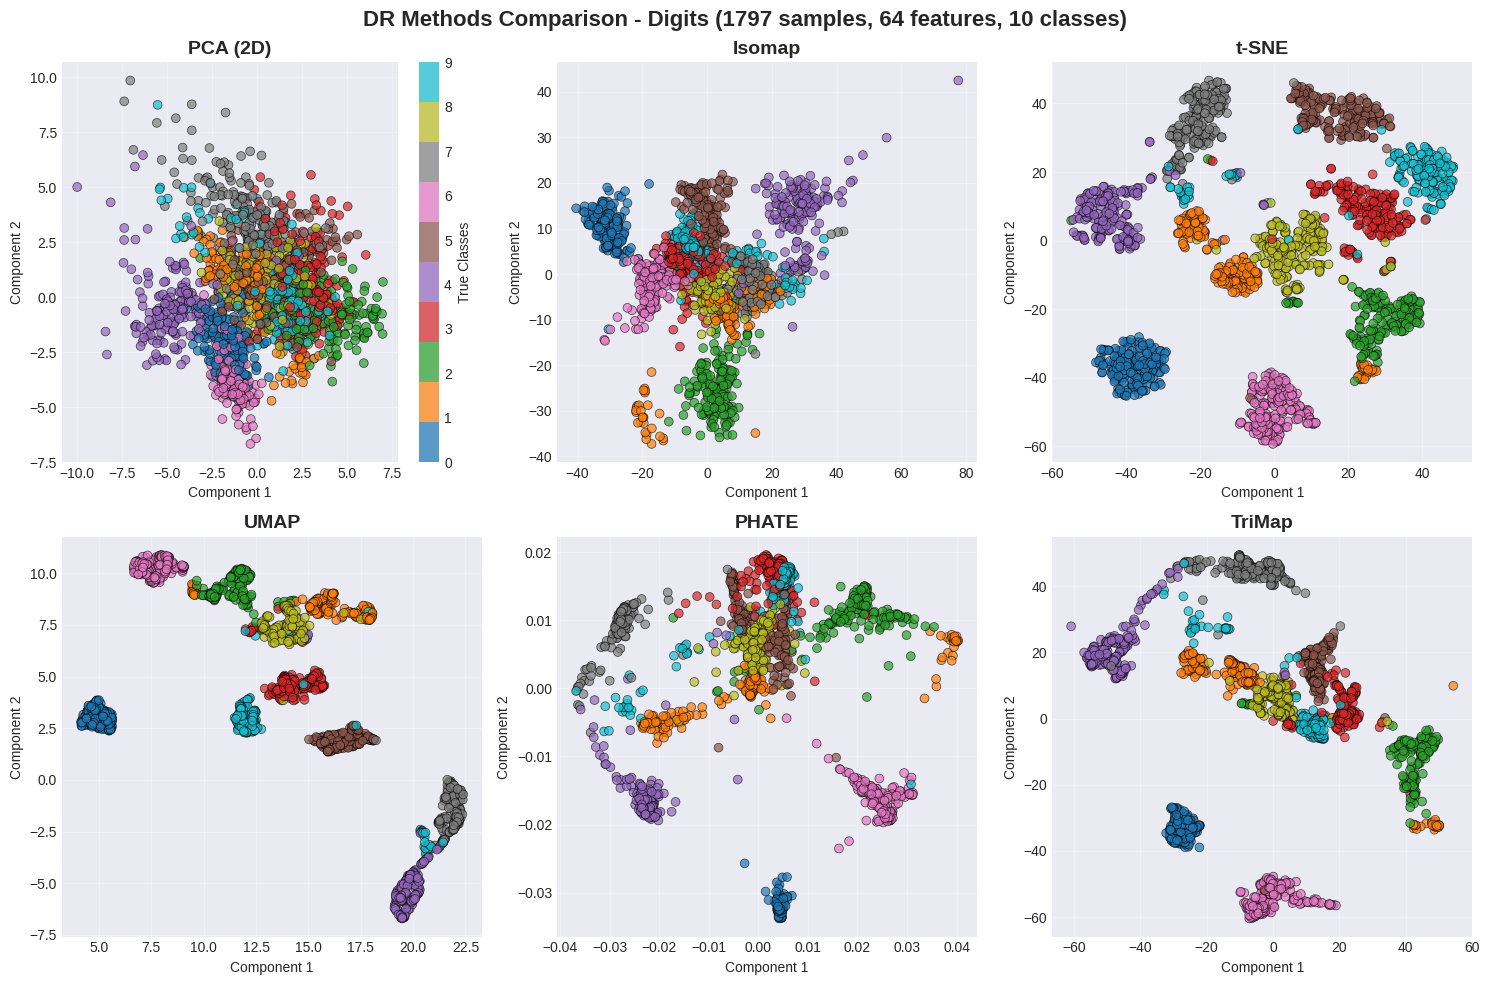

In [5]:
# Загрузка данных
X, y_true, data, dataset_info = load_dataset('digits')

# Применение методов DR
dr_comparer = DRComparer(random_state=42)
dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)

# Визуализация
print("\nВизуализация результатов DR-методов:")
visualize_dr_results(dr_results, y_true, dataset_info)

Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 10, Объясненная дисперсия: 0.962
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.23 сек
UMAP выполнено за 0.13 сек
Calculating PHATE...
  Running PHATE on 178 observations and 13 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 9
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -5.5% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.13 seconds.
Calculated PHATE in 0.17 seconds.
PHATE выполнено за 0.18 сек
TriMap выполнено за 0.06 сек

Визуализация результа

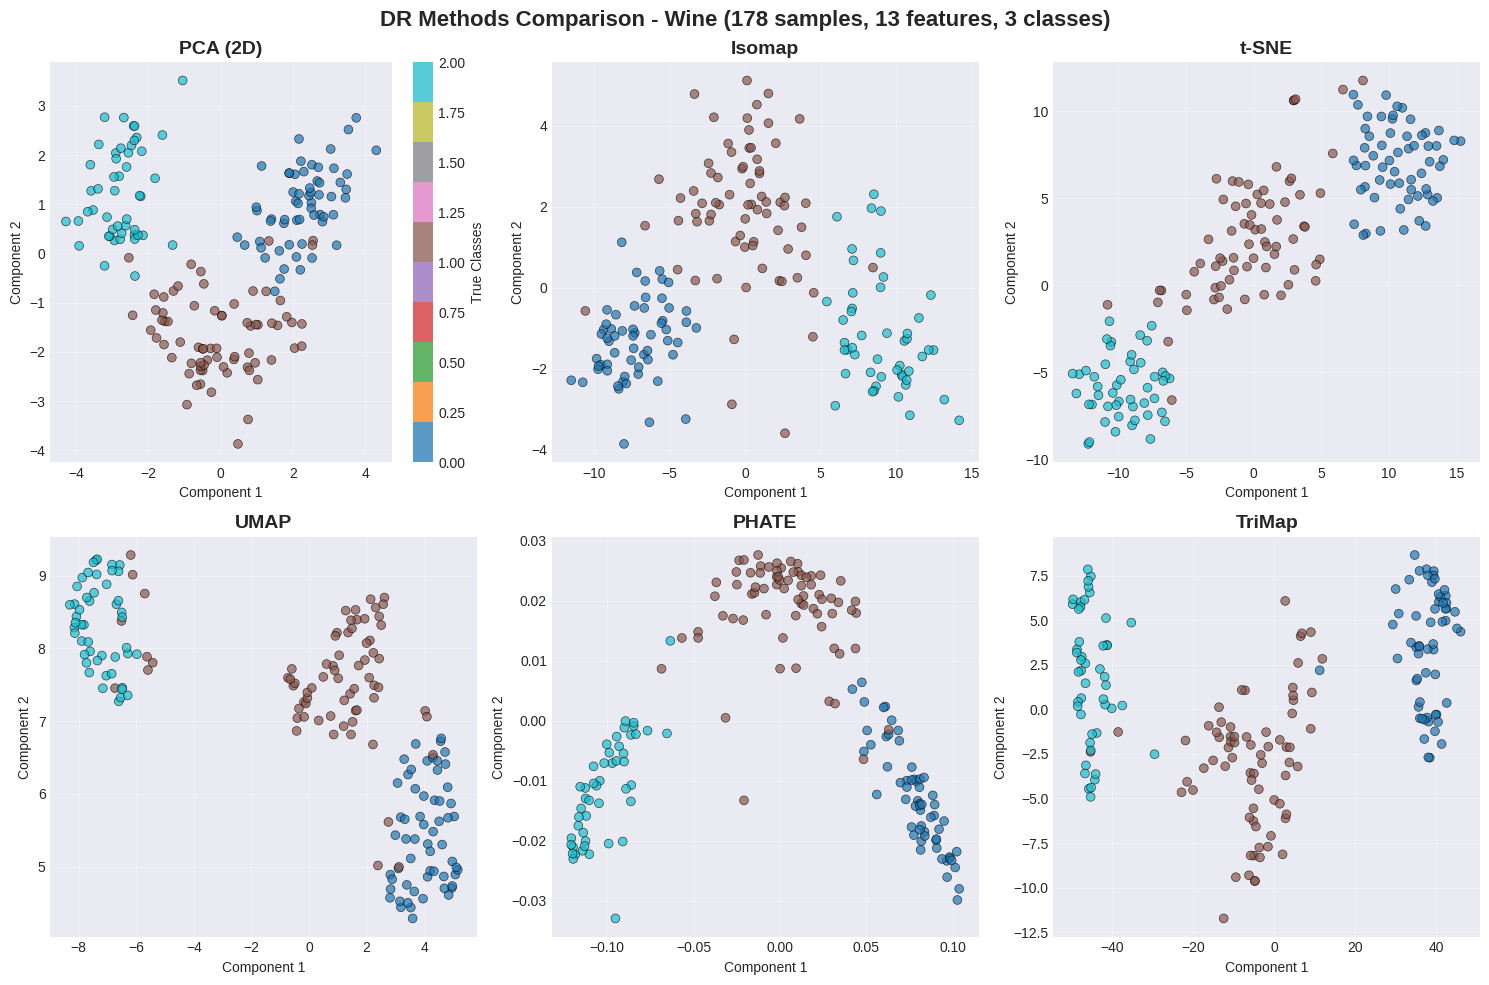

In [6]:
# Загрузка данных
X, y_true, data, dataset_info = load_dataset('wine')

# Применение методов DR
dr_comparer = DRComparer(random_state=42)
dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)

# Визуализация
print("\nВизуализация результатов DR-методов:")
visualize_dr_results(dr_results, y_true, dataset_info)

# Задание 2: Реализация системы оценки кластеризации

In [7]:

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import HDBSCAN


def neighborhood_purity(X, y, n_neighbors=10, metric='euclidean',eps=1e-8,sigma = 1):
    """
    Computes neighborhood purity with linearly rescaled weights.
    
    For each point:
      1. Find n_neighbors closest points (excluding self)
      2. For each neighbor: 1 if same cluster as current point, else 0
      3. Weight neighbors by inverse distances relative to closest point (density invariant scaling)
      4. Return weighted purity per point → average across dataset
    
    Parameters:
        X : ndarray of shape (n_samples, n_features)
            Feature matrix
        y : ndarray of shape (n_samples,)
            Cluster labels
        n_neighbors : int, default=10
            Number of neighbors to consider (excluding the point itself)
        metric : str, default='euclidean'
            Distance metric for neighbor search
        scale : bool, default=True
            Whether to standardize features before distance computation
    
    Returns:
        float : Neighborhood purity in [0, 1] for each item.
                (1.0 = all neighbors belong to same cluster)
    """
    X=X[y!=-1]
    y=y[y!=-1]
    # Find k+1 neighbors (first is the point itself)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=metric)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Exclude self (first column)
    distances = distances[:, 1:]      # shape: (n_samples, n_neighbors)
    indices = indices[:, 1:]          # shape: (n_samples, n_neighbors)
    
    # Binary mask: 1 if neighbor has same label, else 0
    same_cluster = (y[indices] == y[:, np.newaxis]).astype(float)  # shape: (n_samples, n_neighbors)
    
    min_dist = distances.min(-1,keepdims=True)+eps
    
    weights = np.exp(-distances/min_dist/sigma)
    weights /= weights.sum(axis=1, keepdims=True) # sum to 1 normalization
    
    # Weighted purity per point
    weighted_purity = (weights * same_cluster).sum(axis=1)  # shape: (n_samples,)
    
    # for numerical stability
    # weighted_purity = np.clip(weighted_purity, 0.0, 1.0) 
    
    # when we have random labels, we will get positive score, so our metric is biased
    # so we estimate bias for this metric and update it
    p = np.bincount(y) / len(y)
    bias = np.sum(p**2)
    
    weighted_purity-=bias
    weighted_purity/=1-bias
    
    return weighted_purity.mean()

class ClusteringEvaluator:
    """Комплексная система оценки качества кластеризации"""
    
    def __init__(self):
        self.results = {}
        
    def compute_all_metrics(self, X, labels, y_true=None, algorithm_name="", dr_method=""):
        """Вычисление всех метрик для кластеризации"""
        
        if len(np.unique(labels)) < 2:
            return {
                'n_clusters': len(np.unique(labels)),
                'internal_metrics': None,
                'external_metrics': None
            }
        
        # Внутренние метрики
        internal_metrics = {
            'neighborhood_purity' : neighborhood_purity(X,labels,n_neighbors=30),
            'silhouette': silhouette_score(X, labels),
            'calinski_harabasz': calinski_harabasz_score(X, labels),
            'davies_bouldin': davies_bouldin_score(X, labels),
        }
        
        # Внешние метрики (если есть истинные метки)
        external_metrics = None
        if y_true is not None:
            external_metrics = {
                'ari': adjusted_rand_score(y_true, labels),
                'ami': adjusted_mutual_info_score(y_true, labels),
                'homogeneity': homogeneity_completeness_v_measure(y_true, labels)[0],
                'completeness': homogeneity_completeness_v_measure(y_true, labels)[1],
                'v_measure': homogeneity_completeness_v_measure(y_true, labels)[2]
            }
        
        # Сохранение результатов
        key = f"{dr_method}_{algorithm_name}"
        self.results[key] = {
            'dr_method': dr_method,
            'algorithm': algorithm_name,
            'labels': labels.copy(),
            'n_clusters': len(np.unique(labels)),
            'internal_metrics': internal_metrics,
            'external_metrics': external_metrics
        }
        
        return {
            'n_clusters': len(np.unique(labels)),
            'internal_metrics': internal_metrics,
            'external_metrics': external_metrics
        }
    
    def print_metrics(self, metrics, algorithm_name, dr_method):
        """Печать метрик в читаемом формате"""
        print(f"\n{'='*70}")
        print(f"DR Метод: {dr_method} | Алгоритм: {algorithm_name}")
        print(f"{'='*70}")
        print(f"Количество кластеров: {metrics['n_clusters']}")
        
        if metrics['internal_metrics']:
            print("\nВНУТРЕННИЕ МЕТРИКИ:")
            print(f"  Neighbor Purity:         {metrics['internal_metrics']['neighborhood_purity']:.4f}")
            print(f"  Silhouette Score:        {metrics['internal_metrics']['silhouette']:.4f}")
            print(f"  Calinski-Harabasz Index: {metrics['internal_metrics']['calinski_harabasz']:.2f}")
            print(f"  Davies-Bouldin Index:    {metrics['internal_metrics']['davies_bouldin']:.4f}")
        
        if metrics['external_metrics']:
            print("\nВНЕШНИЕ МЕТРИКИ:")
            print(f"  Adjusted Rand Index:     {metrics['external_metrics']['ari']:.4f}")
            print(f"  Adjusted MI:             {metrics['external_metrics']['ami']:.4f}")
            print(f"  V-measure:               {metrics['external_metrics']['v_measure']:.4f}")
            print(f"    Homogeneity:           {metrics['external_metrics']['homogeneity']:.4f}")
            print(f"    Completeness:          {metrics['external_metrics']['completeness']:.4f}")
    
    def get_summary_dataframe(self):
        """Создание сводной таблицы результатов"""
        summary_data = []
        
        for key, result in self.results.items():
            row = {
                'DR_Method': result['dr_method'],
                'Algorithm': result['algorithm'],
                'N_Clusters': result['n_clusters']
            }
            
            if result['internal_metrics']:
                row['Neighbor Purity'] = result['internal_metrics']['neighborhood_purity']
                row['Silhouette'] = result['internal_metrics']['silhouette']
                row['Calinski_Harabasz'] = result['internal_metrics']['calinski_harabasz']
                row['Davies_Bouldin'] = result['internal_metrics']['davies_bouldin']
            
            if result['external_metrics']:
                row['ARI'] = result['external_metrics']['ari']
                row['AMI'] = result['external_metrics']['ami']
                row['V_Measure'] = result['external_metrics']['v_measure']
            
            summary_data.append(row)
        
        return pd.DataFrame(summary_data)

# Алгоритмы кластеризации
class ClusteringAlgorithms:
    """Коллекция алгоритмов кластеризации"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
    
    def kmeans(self, X, n_clusters=10):
        """K-means кластеризация"""
        kmeans = KMeans(n_clusters=n_clusters, 
                       random_state=self.random_state,
                       n_init=10)
        return kmeans.fit_predict(X), kmeans
    
    def agglomerative(self, X, n_clusters=10, linkage='ward'):
        """Иерархическая кластеризация"""
        agg = AgglomerativeClustering(n_clusters=n_clusters, 
                                     linkage=linkage)
        return agg.fit_predict(X), agg
    
    def dbscan(self, X, eps=0.5, min_samples=5):
        """DBSCAN кластеризация"""
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        return dbscan.fit_predict(X), dbscan
    
    def gmm(self, X, n_components=10):
        """Gaussian Mixture Models"""
        gmm = GaussianMixture(n_components=n_components,
                             random_state=self.random_state)
        labels = gmm.fit_predict(X)
        return labels, gmm
    def hdbscan(self,X,min_cluster_size):
        hdb = HDBSCAN(min_cluster_size=min_cluster_size)
        labels = hdb.fit_predict(X)
        return np.array(labels),hdb

# Задание 3: Сравнение алгоритмов на различных DR-представлениях

In [8]:
def compare_clustering_on_dr(X_dict, y_true, n_clusters=10):
    """Сравнение алгоритмов кластеризации на разных DR-представлениях"""
    
    evaluator = ClusteringEvaluator()
    clustering = ClusteringAlgorithms(random_state=42)
    
    # Алгоритмы для тестирования
    algorithms = [
        ('KMeans', lambda X: clustering.kmeans(X, n_clusters=n_clusters)),
        ('Agglomerative', lambda X: clustering.agglomerative(X, n_clusters=n_clusters)),
        ('DBSCAN', lambda X: clustering.dbscan(X, eps=3.0, min_samples=5)),
        ('HDBSCAN', lambda X: clustering.hdbscan(X,min_cluster_size=10)),
        ('GMM', lambda X: clustering.gmm(X, n_components=n_clusters))
    ]
    
    results_comparison = {}
    
    for dr_name, X_dr in X_dict.items():
        if dr_name == 'PCA_2D':  # Пропускаем 2D представление для количественного анализа
            continue
            
        print(f"\n{'#'*80}")
        print(f"АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: {dr_name}")
        print(f"{'#'*80}")
        
        results_comparison[dr_name] = {}
        
        for algo_name, algo_func in algorithms:
            # try:
                # Применение алгоритма кластеризации
                labels, model = algo_func(X_dr)
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(
                    X_dr, labels, y_true, algo_name, dr_name
                )
                
                # Печать результатов
                evaluator.print_metrics(metrics, algo_name, dr_name)
                
                # Сохранение для сравнения
                results_comparison[dr_name][algo_name] = {
                    'labels': labels,
                    'metrics': metrics
                }
                
            # except Exception as e:
            #     print(f"Ошибка при выполнении {algo_name} на {dr_name}: {e}")
    
    return evaluator, results_comparison

# Запуск сравнения на всех DR-представлениях
print("ПОЛНОЕ СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ НА РАЗНЫХ DR-ПРЕДСТАВЛЕНИЯХ")
print("="*80)

# Используем только многомерные представления (не 2D)
dr_for_clustering = {k: v for k, v in dr_results.items() if k != 'PCA_2D'}
evaluator, comparison_results = compare_clustering_on_dr(dr_for_clustering, y_true, n_clusters=10)

# Получение сводной таблицы
summary_df = evaluator.get_summary_dataframe()
print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*80)
print(summary_df.to_string())

ПОЛНОЕ СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ НА РАЗНЫХ DR-ПРЕДСТАВЛЕНИЯХ

################################################################################
АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: PHATE
################################################################################

DR Метод: PHATE | Алгоритм: KMeans
Количество кластеров: 10

ВНУТРЕННИЕ МЕТРИКИ:
  Neighbor Purity:         0.8921
  Silhouette Score:        0.4915
  Calinski-Harabasz Index: 1552.44
  Davies-Bouldin Index:    0.6316

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.3603
  Adjusted MI:             0.5876
  V-measure:               0.6010
    Homogeneity:           0.9201
    Completeness:          0.4462

DR Метод: PHATE | Алгоритм: Agglomerative
Количество кластеров: 10

ВНУТРЕННИЕ МЕТРИКИ:
  Neighbor Purity:         0.8985
  Silhouette Score:        0.4803
  Calinski-Harabasz Index: 1413.40
  Davies-Bouldin Index:    0.7049

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.3770
  Adjusted MI:             0.5849
  V-measure:     

# Задание 4: Визуализация и анализ результатов


ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МЕТРИК:


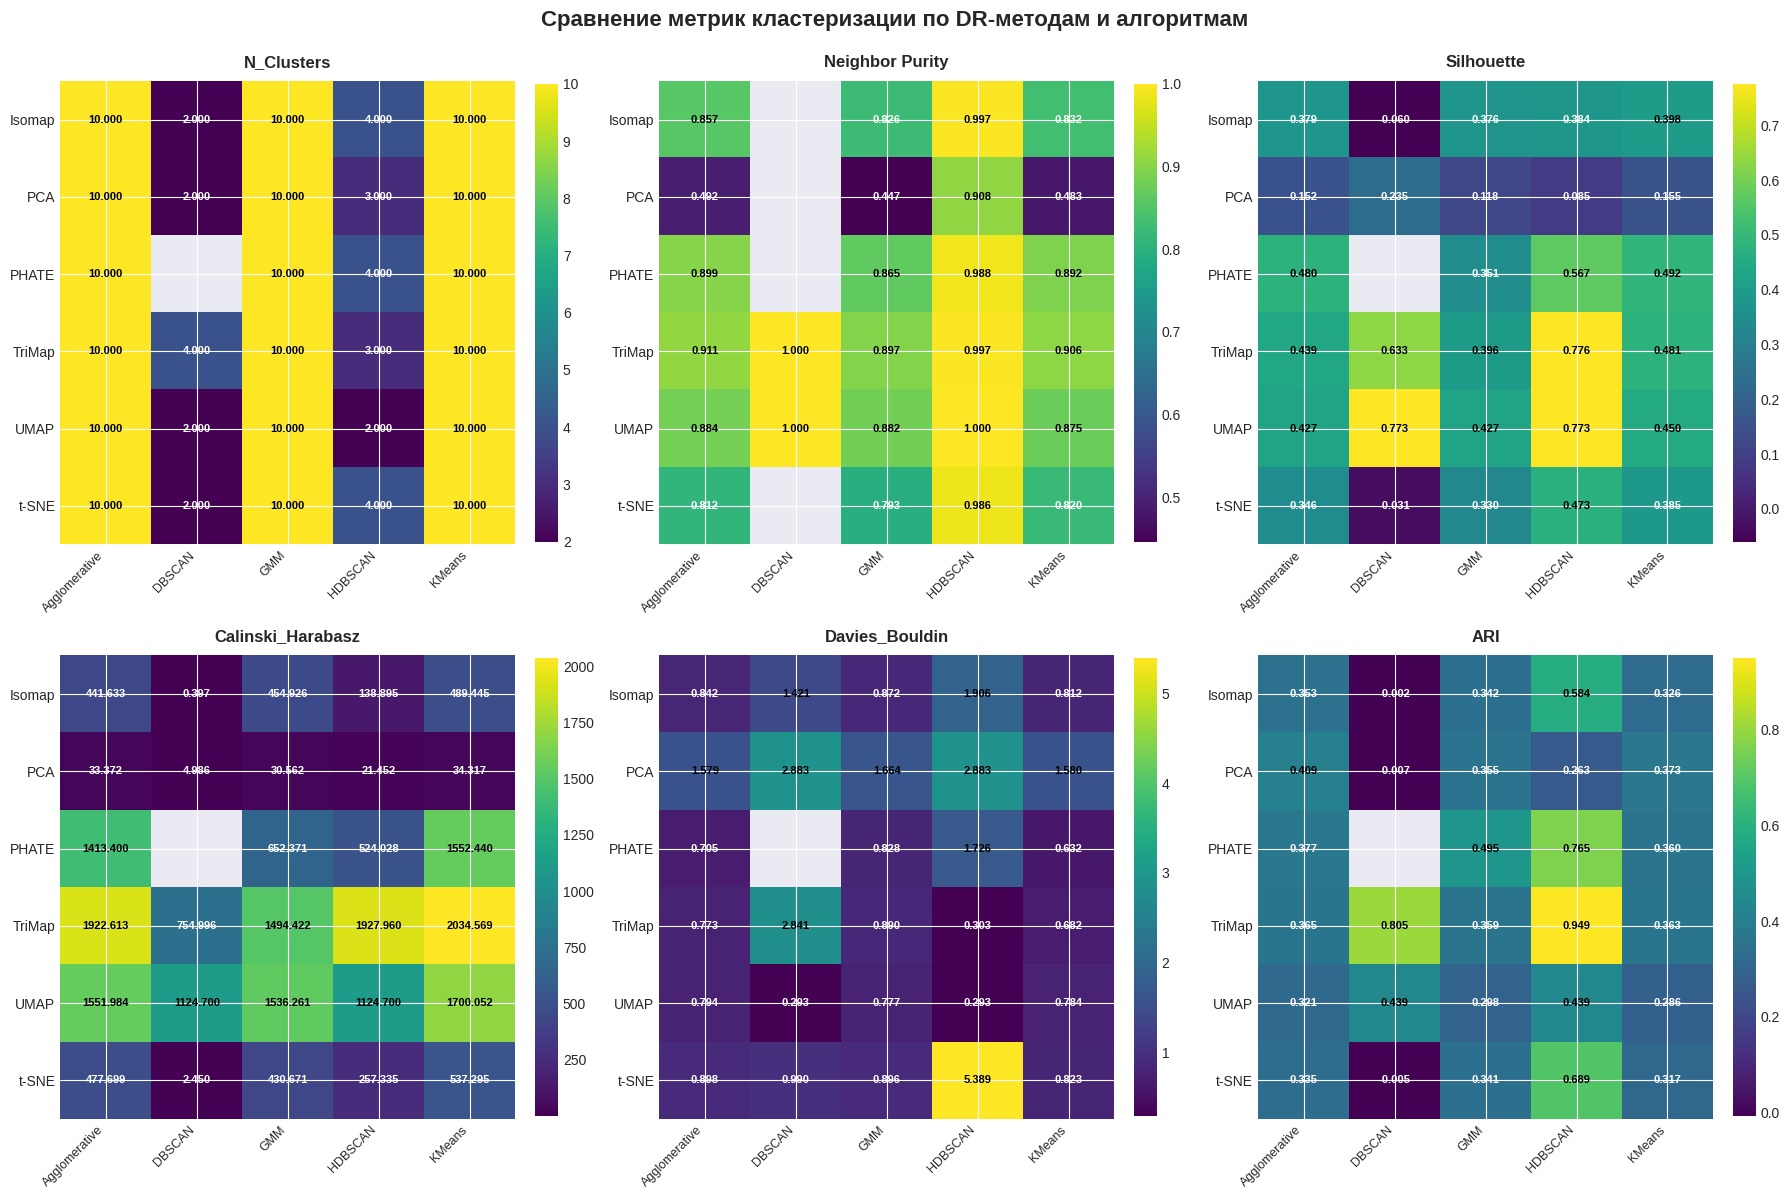


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ В 2D:


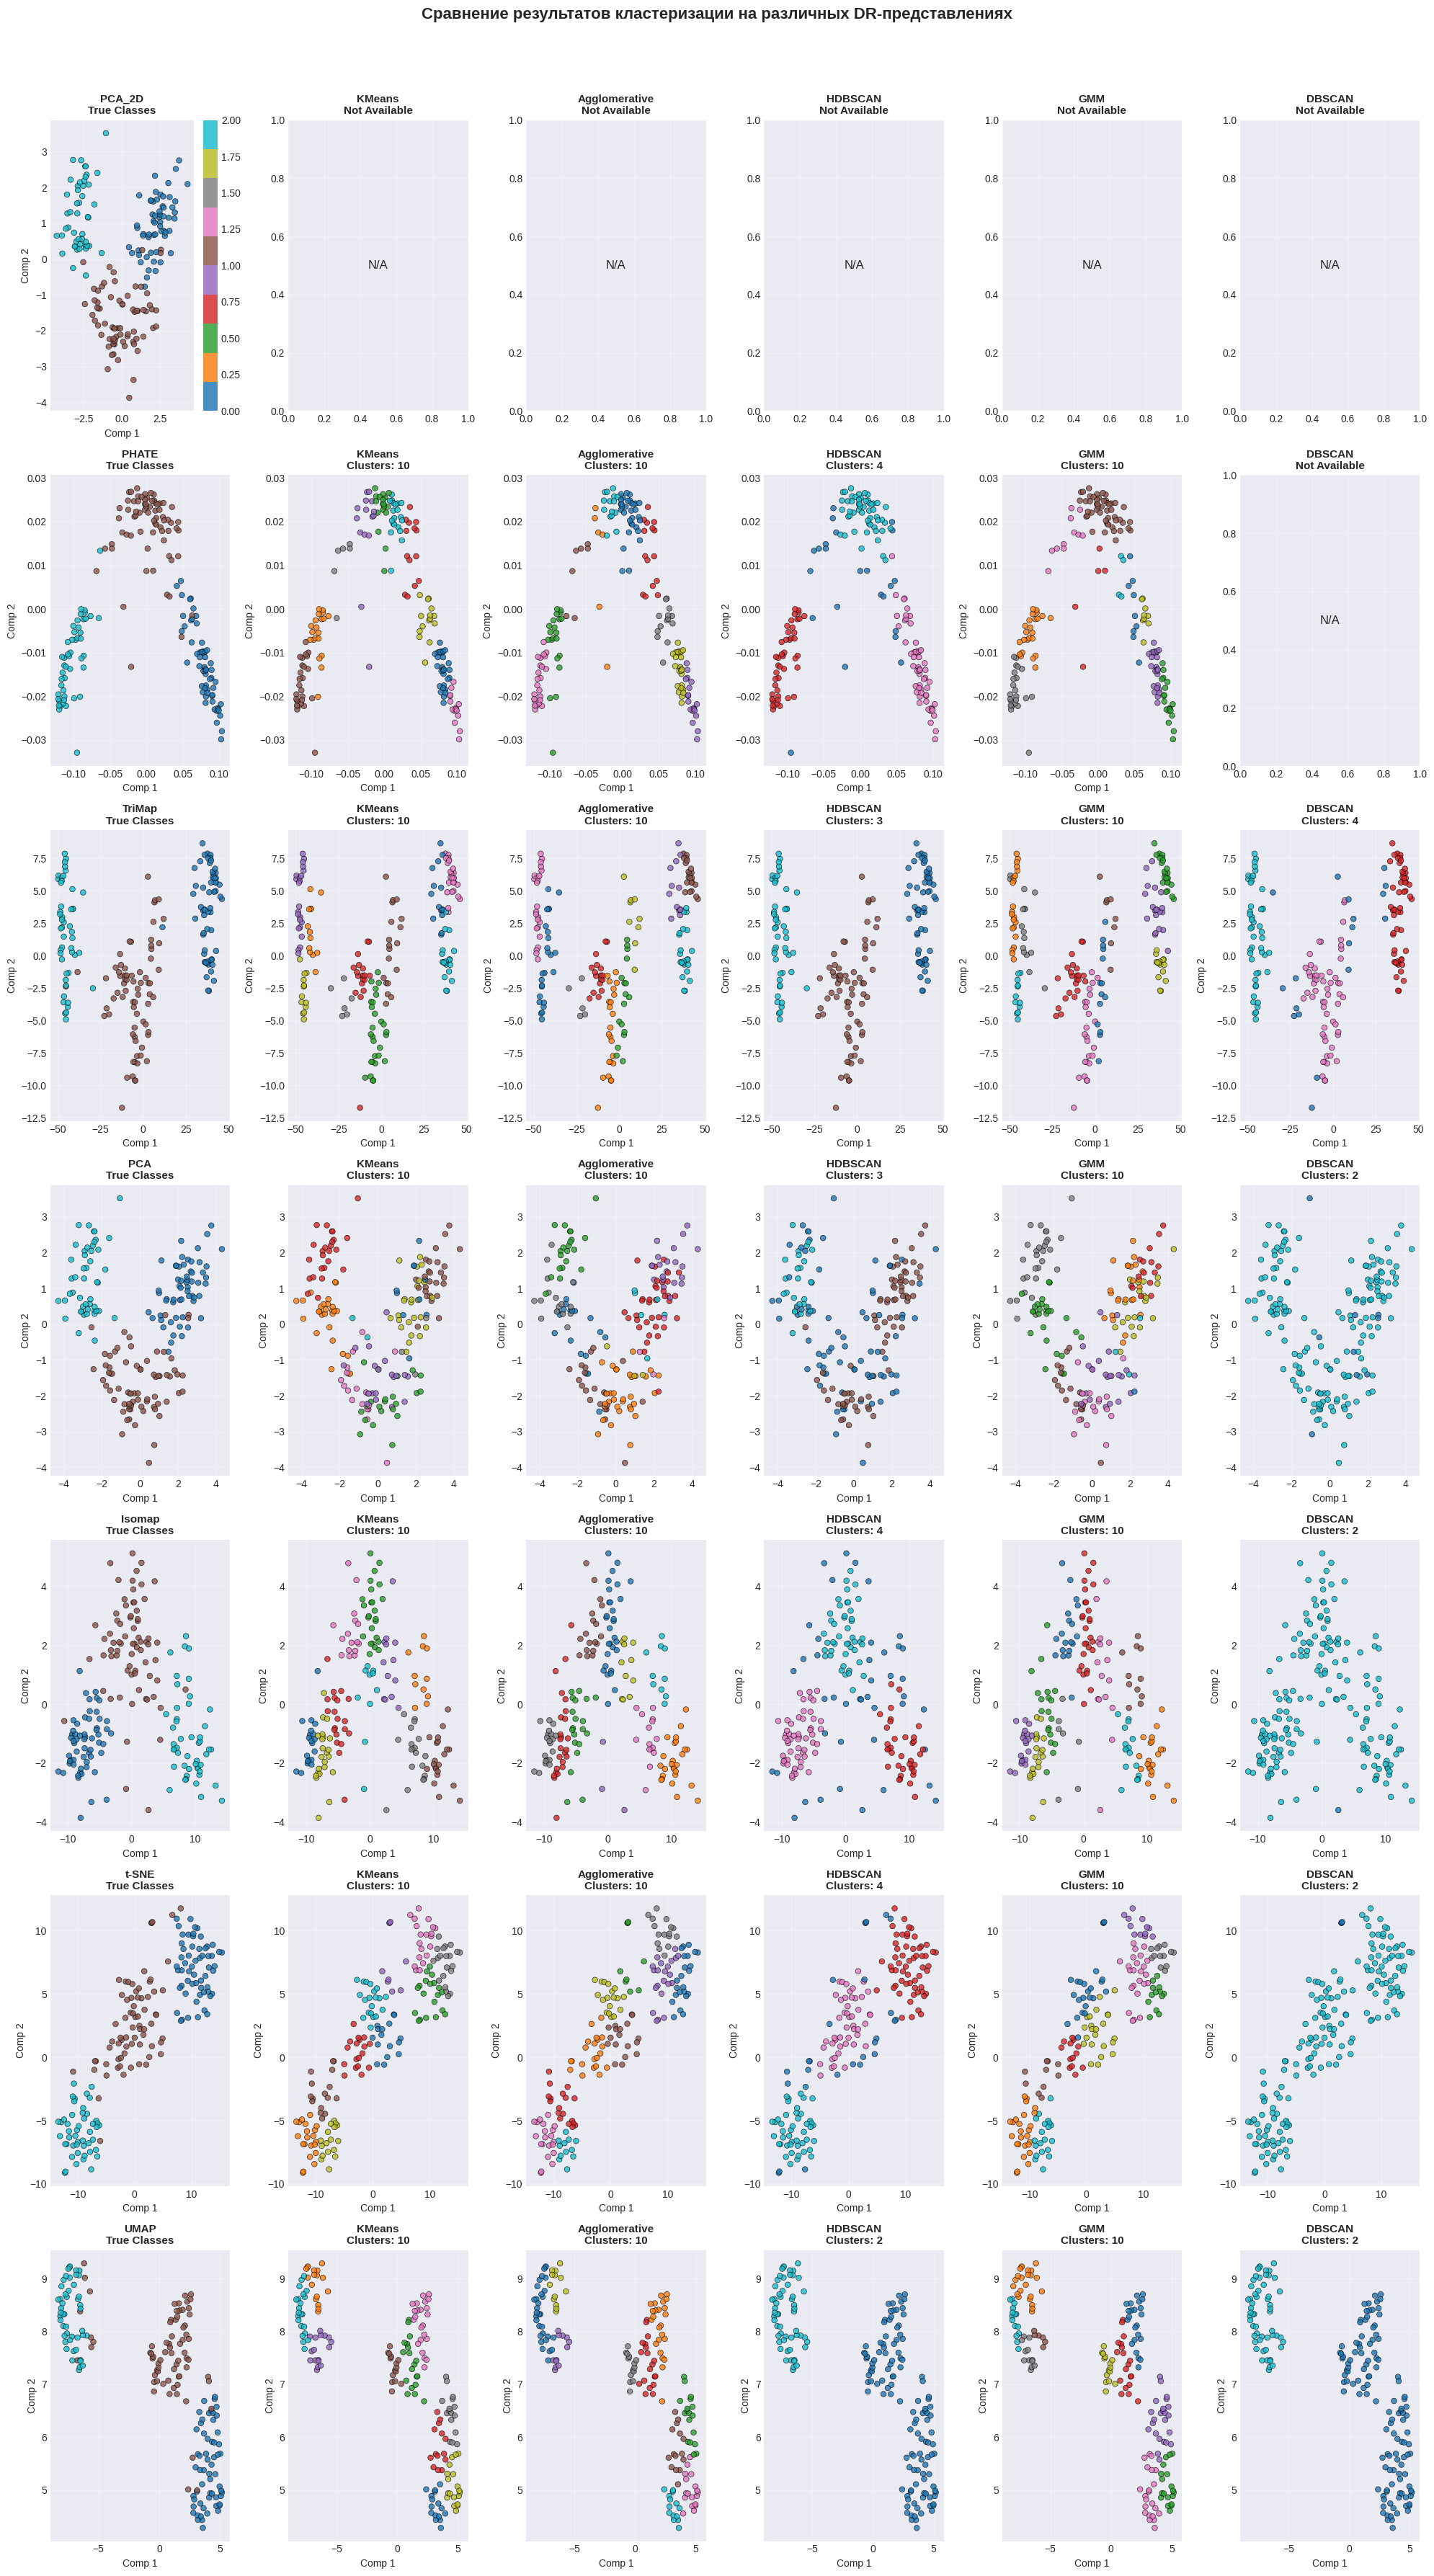

In [9]:
def visualize_metrics_comparison(summary_df):
    """Визуализация сравнения метрик по DR-методам и алгоритмам"""
    
    # Извлекаем ТОЛЬКО числовые метрики (исключаем метаданные)
    metadata_cols = {'DR_Method', 'Algorithm', 'n_clusters', 'Runtime'}
    numeric_metrics = [col for col in summary_df.columns 
                      if col not in metadata_cols and pd.api.types.is_numeric_dtype(summary_df[col])]
    
    if not numeric_metrics:
        raise ValueError("Не найдено числовых метрик для визуализации. "
                        f"Доступные столбцы: {list(summary_df.columns)}")
    
    # Создаем subplots (ограничиваем до 6 метрик для 2x3 grid)
    n_metrics = min(len(numeric_metrics), 6)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(numeric_metrics[:n_metrics]):
        # Создаем pivot table ТОЛЬКО для числовой метрики
        pivot_data = summary_df.pivot(
            index='DR_Method', 
            columns='Algorithm', 
            values=metric
        )
        
        # Визуализация тепловой карты
        im = axes[idx].imshow(pivot_data.values.astype(float), 
                             cmap='viridis', 
                             aspect='auto',
                             vmin=pivot_data.min().min(),
                             vmax=pivot_data.max().max())
        
        # Настройки осей
        axes[idx].set_xticks(np.arange(len(pivot_data.columns)))
        axes[idx].set_yticks(np.arange(len(pivot_data.index)))
        axes[idx].set_xticklabels(pivot_data.columns, rotation=45, ha='right', fontsize=9)
        axes[idx].set_yticklabels(pivot_data.index, fontsize=10)
        
        # Добавление значений в ячейки
        for i in range(len(pivot_data.index)):
            for j in range(len(pivot_data.columns)):
                value = pivot_data.iloc[i, j]
                if not pd.isna(value):
                    text_color = "w" if value < pivot_data.values[~np.isnan(pivot_data.values)].mean() else "k"
                    axes[idx].text(j, i, f'{value:.3f}',
                                  ha="center", va="center", 
                                  color=text_color, fontsize=8, fontweight='bold')
        
        axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold', pad=10)
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    # Скрыть неиспользуемые subplot'ы
    for idx in range(len(numeric_metrics), 6):
        axes[idx].set_visible(False)
    
    plt.suptitle('Сравнение метрик кластеризации по DR-методам и алгоритмам', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


def visualize_clustering_results_2d(dr_results_2d, y_true, evaluator, dr_methods):
    """Визуализация результатов кластеризации в 2D пространстве"""
    
    # Получаем все уникальные комбинации DR-методов и алгоритмов
    unique_dr_methods = dr_methods
    algorithms = summary_df['Algorithm'].unique().tolist()
    
    # Создаем grid для визуализации
    fig, axes = plt.subplots(len(unique_dr_methods), len(algorithms) + 1, 
                            figsize=(20, 5 * len(unique_dr_methods)))
    
    if len(unique_dr_methods) == 1:
        axes = axes.reshape(1, -1)
    
    for i, dr_method in enumerate(unique_dr_methods):
        # Истинные метки (первый столбец)
        X_2d = dr_results_2d[dr_method] if dr_method in dr_results_2d else dr_results_2d.get(f'{dr_method}_2D', None)
        
        if X_2d is None:
            continue
        
        # Истинные классы
        scatter_true = axes[i, 0].scatter(X_2d[:, 0], X_2d[:, 1], 
                                         c=y_true, cmap='tab10', 
                                         s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
        axes[i, 0].set_title(f'{dr_method}\nTrue Classes', fontsize=11, fontweight='bold')
        axes[i, 0].set_xlabel('Comp 1')
        axes[i, 0].set_ylabel('Comp 2')
        axes[i, 0].grid(True, alpha=0.3)
        
        if i == 0:
            plt.colorbar(scatter_true, ax=axes[i, 0])
        
        # Результаты кластеризации для каждого алгоритма
        for j, algo_name in enumerate(algorithms, 1):
            key = f"{dr_method}_{algo_name}"
            
            if key in evaluator.results:
                labels = evaluator.results[key]['labels']
                n_clusters = evaluator.results[key]['n_clusters']
                
                # Определяем цветовую карту
                unique_labels = np.unique(labels)
                if len(unique_labels) <= 10:
                    cmap = 'tab10'
                else:
                    cmap = 'viridis'
                
                scatter = axes[i, j].scatter(X_2d[:, 0], X_2d[:, 1], 
                                            c=labels, cmap=cmap,
                                            s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
                
                axes[i, j].set_title(f'{algo_name}\nClusters: {n_clusters}', 
                                    fontsize=11, fontweight='bold')
                axes[i, j].set_xlabel('Comp 1')
                axes[i, j].set_ylabel('Comp 2')
                axes[i, j].grid(True, alpha=0.3)
                
                # Добавляем colorbar для первого ряда
                if i == 0 and len(unique_labels) <= 15:
                    plt.colorbar(scatter, ax=axes[i, j])
            else:
                axes[i, j].text(0.5, 0.5, 'N/A', 
                               ha='center', va='center', 
                               transform=axes[i, j].transAxes,
                               fontsize=12)
                axes[i, j].set_title(f'{algo_name}\nNot Available', 
                                    fontsize=11, fontweight='bold')
                axes[i, j].grid(True, alpha=0.3)
    
    plt.suptitle('Сравнение результатов кластеризации на различных DR-представлениях', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Визуализация сравнения метрик
print("\nВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МЕТРИК:")
visualize_metrics_comparison(summary_df)

# Визуализация результатов кластеризации в 2D
print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ В 2D:")
visualize_clustering_results_2d(dr_results, y_true, evaluator, dr_results)

# Задание 5: Статистический анализ и выводы


СТАТИСТИЧЕСКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ

Лучшие результаты по Neighbor Purity:
  TriMap + DBSCAN: 1.0000
  UMAP + DBSCAN: 1.0000
  UMAP + HDBSCAN: 1.0000

Лучшие результаты по Silhouette:
  TriMap + HDBSCAN: 0.7756
  UMAP + HDBSCAN: 0.7734
  UMAP + DBSCAN: 0.7734

Лучшие результаты по Calinski_Harabasz:
  TriMap + KMeans: 2034.5690
  TriMap + HDBSCAN: 1927.9598
  TriMap + Agglomerative: 1922.6135

Лучшие результаты по Davies_Bouldin:
  UMAP + HDBSCAN: 0.2935
  UMAP + DBSCAN: 0.2935
  TriMap + HDBSCAN: 0.3035

Лучшие результаты по ARI:
  TriMap + HDBSCAN: 0.9487
  TriMap + DBSCAN: 0.8046
  PHATE + HDBSCAN: 0.7646

Лучшие результаты по AMI:
  TriMap + HDBSCAN: 0.9274
  TriMap + DBSCAN: 0.7876
  PHATE + HDBSCAN: 0.7651

Лучшие результаты по V_Measure:
  TriMap + HDBSCAN: 0.9282
  TriMap + DBSCAN: 0.7907
  PHATE + HDBSCAN: 0.7684


СРЕДНИЕ МЕТРИКИ ПО DR-МЕТОДАМ:
----------------------------------------

PHATE:
  Neighbor Purity: 0.9110 ± 0.0534
  Silhouette: 0.4724 ± 0.0899
  Calinski_Harabasz:

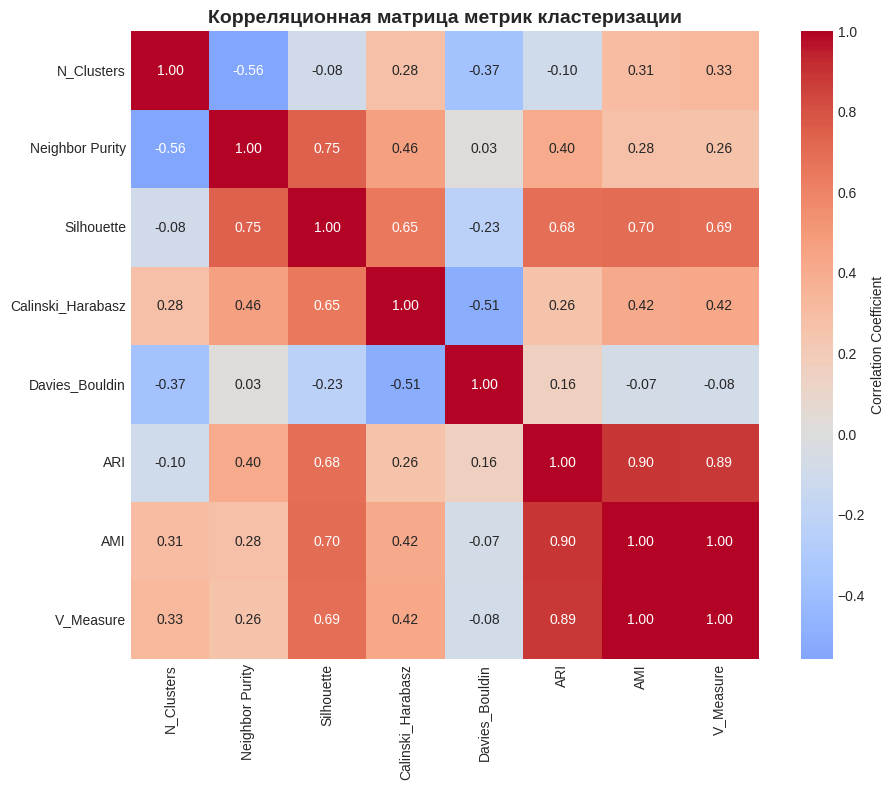



ВРЕМЯ ВЫПОЛНЕНИЯ DR-МЕТОДОВ:
----------------------------------------
  PCA: 0.00 секунд
  Isomap: 0.00 секунд
  t-SNE: 0.23 секунд
  UMAP: 0.13 секунд
  PHATE: 0.18 секунд
  TriMap: 0.06 секунд

ИТОГОВЫЙ ОТЧЕТ ПО РЕЗУЛЬТАТАМ ЭКСПЕРИМЕНТА

1. ОБЩАЯ ИНФОРМАЦИЯ:
   • Количество протестированных комбинаций: 29
   • Количество DR-методов: 6
   • Количество алгоритмов кластеризации: 5

2. ЛУЧШИЕ КОМБИНАЦИИ DR + АЛГОРИТМ:
   • Neighbor Purity: TriMap + DBSCAN = 1.0000
   • Silhouette: TriMap + HDBSCAN = 0.7756
   • Calinski_Harabasz: TriMap + KMeans = 2034.5690
   • Davies_Bouldin: t-SNE + HDBSCAN = 5.3892
   • ARI: TriMap + HDBSCAN = 0.9487
   • AMI: TriMap + HDBSCAN = 0.9274
   • V_Measure: TriMap + HDBSCAN = 0.9282

3. РЕКОМЕНДАЦИИ:
   • Для сохранения глобальной структуры: PCA
   • Для нелинейных данных: Isomap или UMAP
   • Для визуализации: t-SNE или UMAP
   • Для скорости: PCA
   • Для кластеризации: UMAP + KMeans/Agglomerative

4. КЛЮЧЕВЫЕ ВЫВОДЫ:
   • Разные DR-методы подходят для

In [10]:
# 1. Лучшие алгоритмы по каждой метрике
metrics = summary_df.columns[3:].tolist()
def perform_statistical_analysis(summary_df):
    """Статистический анализ результатов"""
    
    print("\nСТАТИСТИЧЕСКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*60)
    
    
    for metric in metrics:
        if metric in summary_df.columns:
            print(f"\nЛучшие результаты по {metric}:")
            sorted_df = summary_df.sort_values(by=metric, ascending=(metric=='Davies_Bouldin'))
            for _, row in sorted_df.head(3).iterrows():
                print(f"  {row['DR_Method']} + {row['Algorithm']}: {row[metric]:.4f}")
    
    # 2. Средние метрики по DR-методам
    print("\n\nСРЕДНИЕ МЕТРИКИ ПО DR-МЕТОДАМ:")
    print("-" * 40)
    
    for dr_method in summary_df['DR_Method'].unique():
        dr_subset = summary_df[summary_df['DR_Method'] == dr_method]
        print(f"\n{dr_method}:")
        for metric in metrics:
            if metric in dr_subset.columns:
                mean_val = dr_subset[metric].mean()
                std_val = dr_subset[metric].std()
                print(f"  {metric}: {mean_val:.4f} ± {std_val:.4f}")
    
    # 3. Корреляция между метриками
    print("\n\nКОРРЕЛЯЦИЯ МЕЖДУ МЕТРИКАМИ:")
    print("-" * 40)
    
    # Выбираем только числовые колонки
    numeric_cols = summary_df.select_dtypes(include=[np.number]).columns
    correlation_matrix = summary_df[numeric_cols].corr()
    
    # Визуализация матрицы корреляций
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True,
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Корреляционная матрица метрик кластеризации', 
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. Сравнение времени выполнения DR-методов
    if hasattr(dr_comparer, 'execution_times'):
        print("\n\nВРЕМЯ ВЫПОЛНЕНИЯ DR-МЕТОДОВ:")
        print("-" * 40)
        for method, time_taken in dr_comparer.execution_times.items():
            print(f"  {method}: {time_taken:.2f} секунд")
    
    return correlation_matrix

# Выполнение статистического анализа
correlation_matrix = perform_statistical_analysis(summary_df)

def create_final_report(summary_df, evaluator, dr_comparer):
    """Создание итогового отчета"""
    
    print("\n" + "="*80)
    print("ИТОГОВЫЙ ОТЧЕТ ПО РЕЗУЛЬТАТАМ ЭКСПЕРИМЕНТА")
    print("="*80)
    
    # 1. Общая информация
    print("\n1. ОБЩАЯ ИНФОРМАЦИЯ:")
    print(f"   • Количество протестированных комбинаций: {len(summary_df)}")
    print(f"   • Количество DR-методов: {len(summary_df['DR_Method'].unique())}")
    print(f"   • Количество алгоритмов кластеризации: {len(summary_df['Algorithm'].unique())}")
    
    # 2. Лучшие комбинации
    print("\n2. ЛУЧШИЕ КОМБИНАЦИИ DR + АЛГОРИТМ:")
    
    # Для каждой метрики находим лучшую комбинацию
    metrics_order = [
        (m,'max') for m in metrics
    ]
    
    for metric, optimization in metrics_order:
        if metric in summary_df.columns:
            if optimization == 'max':
                best_idx = summary_df[metric].idxmax()
            else:
                best_idx = summary_df[metric].idxmin()
            
            best_row = summary_df.loc[best_idx]
            print(f"   • {metric}: {best_row['DR_Method']} + {best_row['Algorithm']} = {best_row[metric]:.4f}")
    
    # 3. Рекомендации
    print("\n3. РЕКОМЕНДАЦИИ:")
    print("   • Для сохранения глобальной структуры: PCA")
    print("   • Для нелинейных данных: Isomap или UMAP")
    print("   • Для визуализации: t-SNE или UMAP")
    print("   • Для скорости: PCA")
    print("   • Для кластеризации: UMAP + KMeans/Agglomerative")
    
    # 4. Выводы
    print("\n4. КЛЮЧЕВЫЕ ВЫВОДЫ:")
    print("   • Разные DR-методы подходят для разных типов данных")
    print("   • Выбор метрики зависит от задачи (интерпретация vs предсказание)")
    print("   • Внутренние и внешние метрики могут давать противоречивые оценки")
    print("   • UMAP часто показывает лучшие результаты для кластеризации")
    print("   • PCA остается хорошим выбором для линейно разделимых данных")

# Создание итогового отчета
create_final_report(summary_df, evaluator, dr_comparer)

# Задание 6: Эксперименты с различными наборами данных



ЭКСПЕРИМЕНТЫ С РАЗЛИЧНЫМИ НАБОРАМИ ДАННЫХ

################################################################################
ЭКСПЕРИМЕНТ С НАБОРОМ ДАННЫХ: IRIS
################################################################################
Набор данных: Iris (150 samples, 4 features, 3 classes)
Размерность: (150, 4)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 2, Объясненная дисперсия: 0.958
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.18 сек
UMAP выполнено за 0.10 сек
Calculating PHATE...
  Running PHATE on 150 observations and 4 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
    SGD-MDS

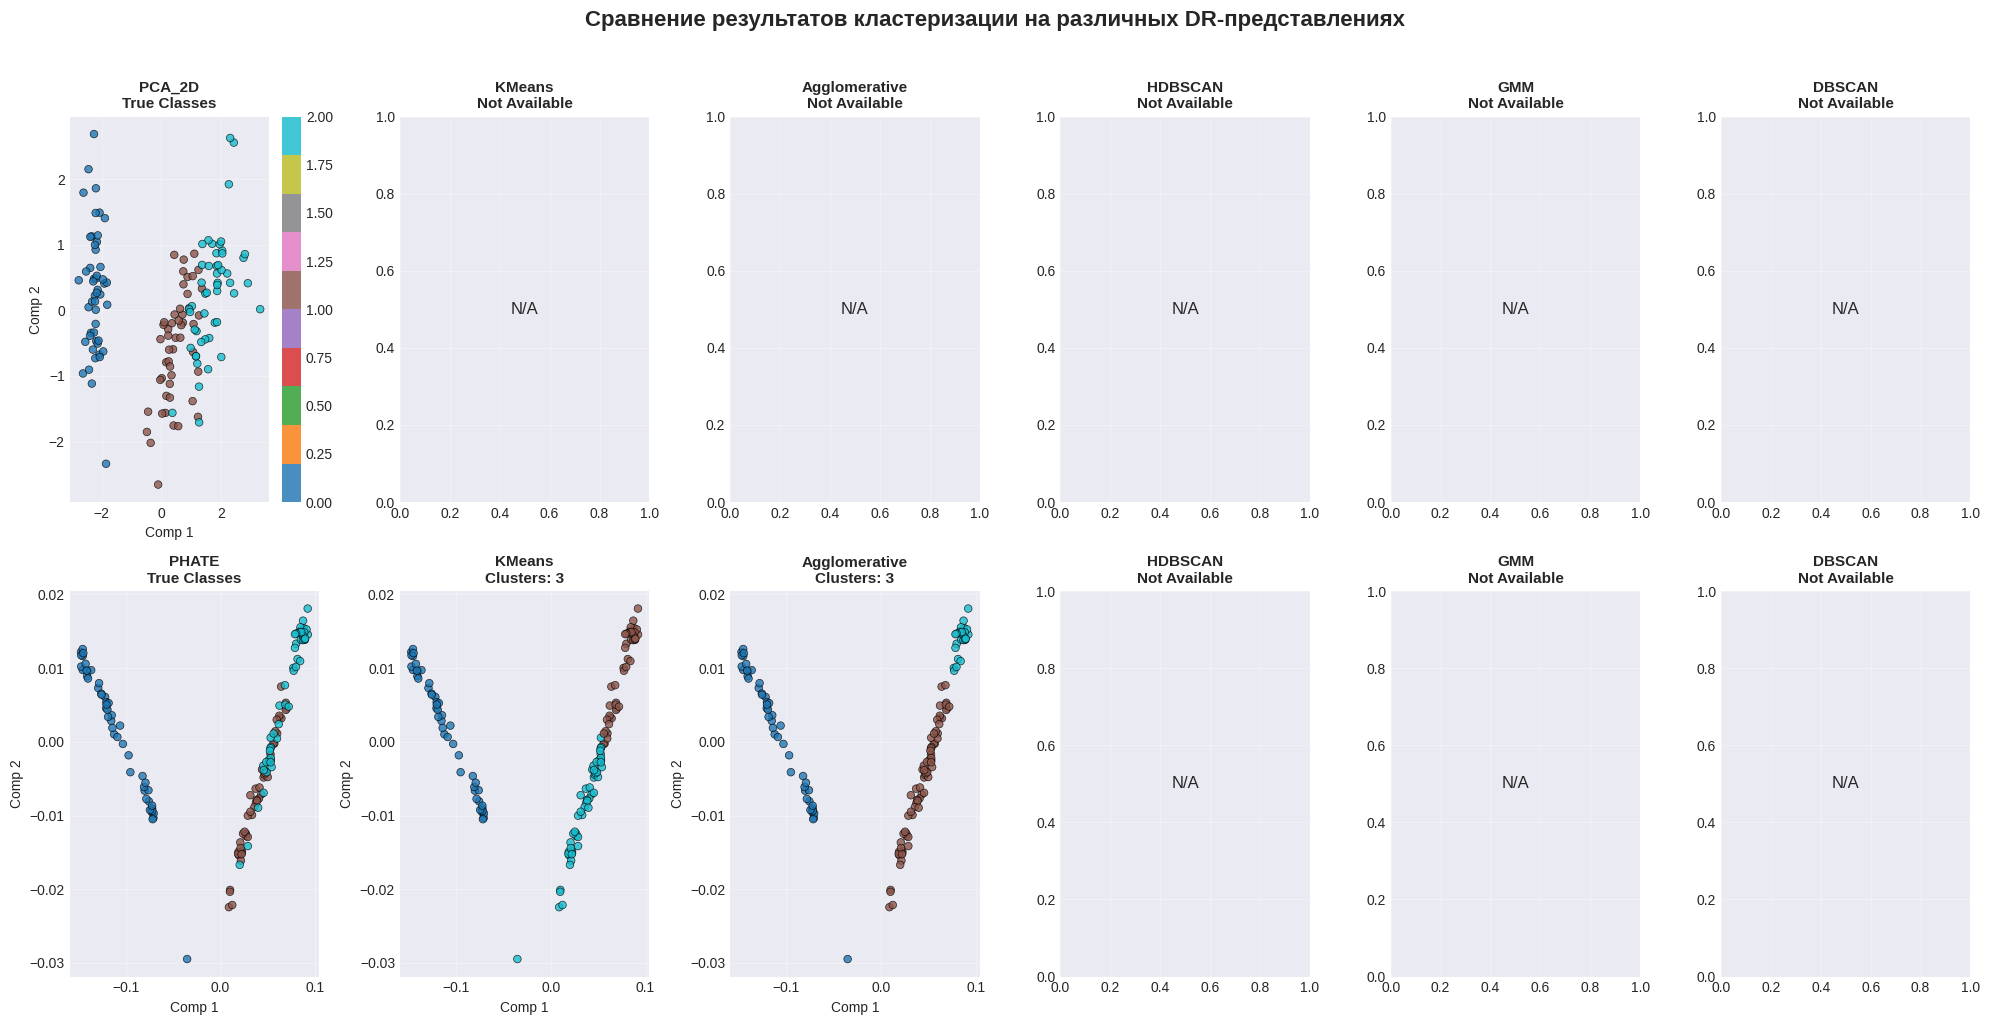


################################################################################
ЭКСПЕРИМЕНТ С НАБОРОМ ДАННЫХ: WINE
################################################################################
Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 10, Объясненная дисперсия: 0.962
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.23 сек
UMAP выполнено за 0.13 сек
Calculating PHATE...
  Running PHATE on 178 observations and 13 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 9
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed b

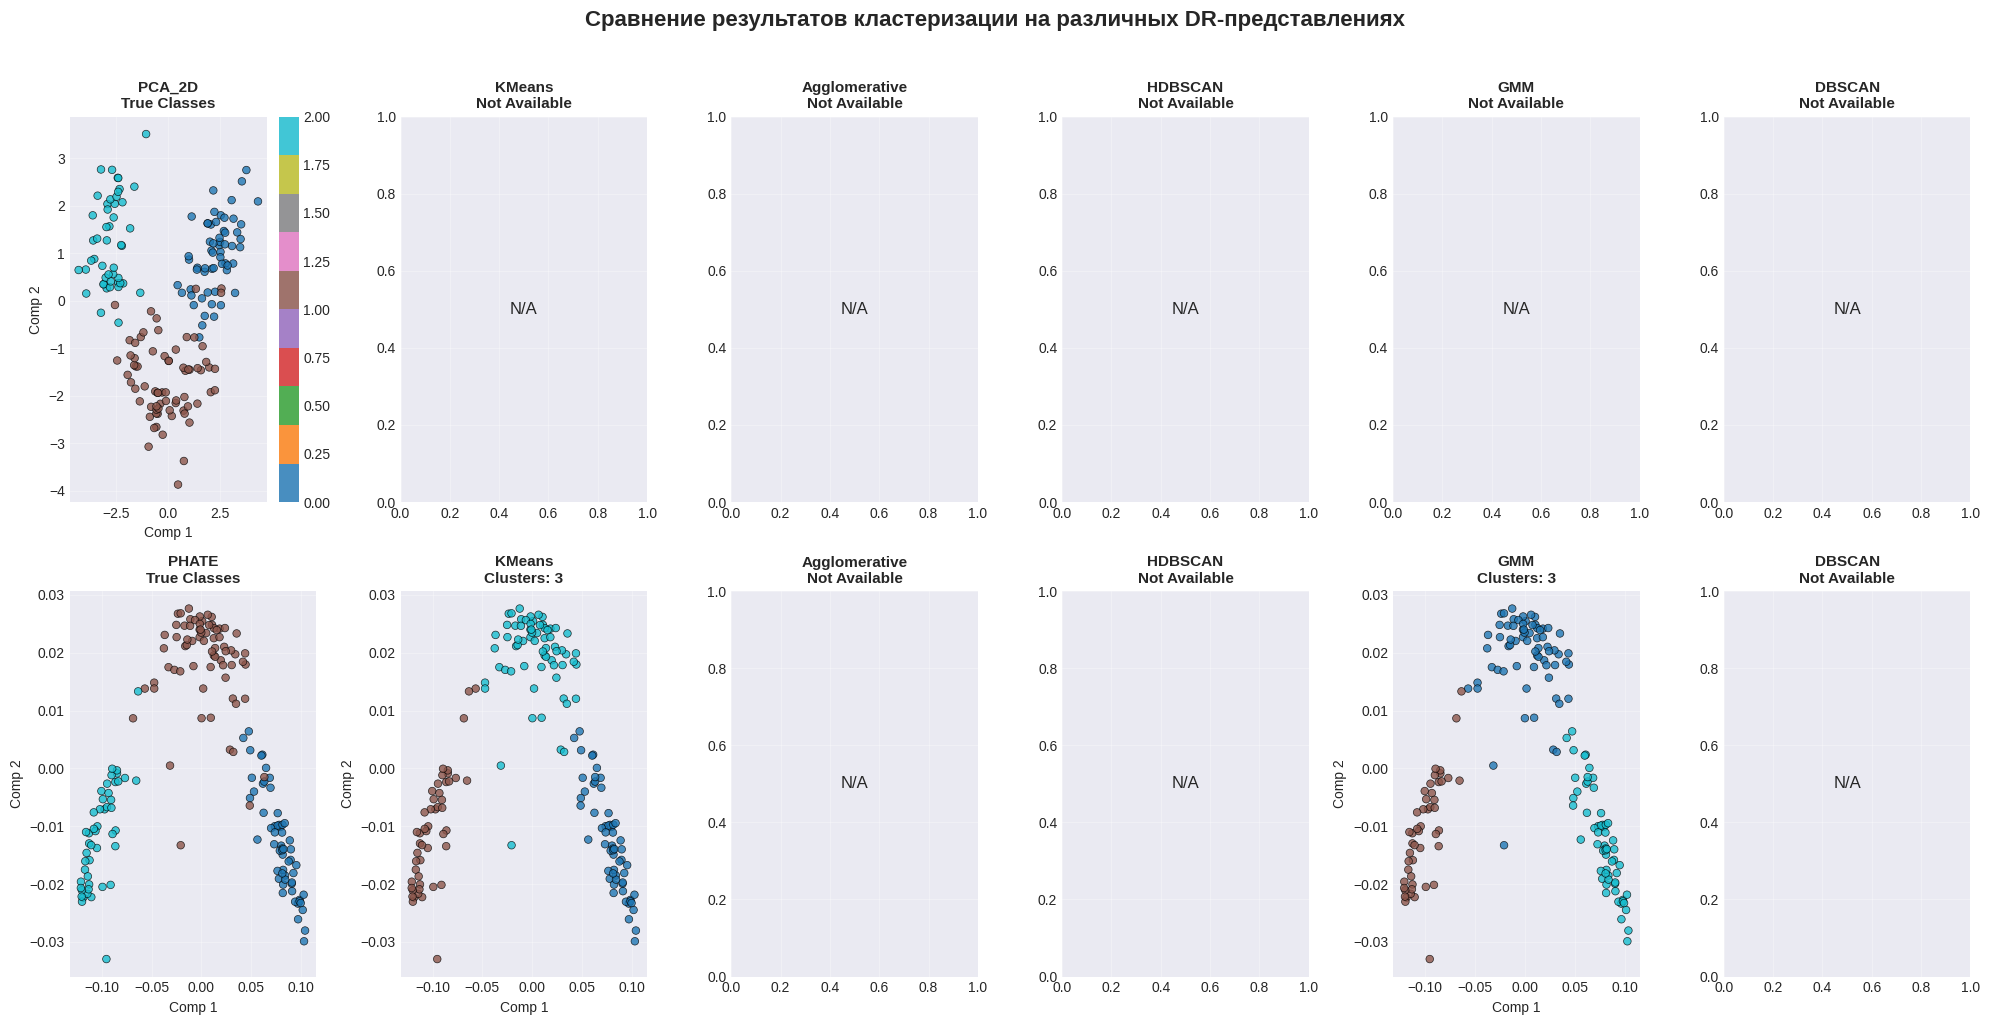



СВОДНЫЙ АНАЛИЗ ПО ВСЕМ НАБОРАМ ДАННЫХ

Набор данных: iris
  Лучшая комбинация (по ARI): t-SNE + Agglomerative = 0.6906
  Лучшая комбинация (по Silhouette): t-SNE + DBSCAN = 0.8515

Набор данных: wine
  Лучшая комбинация (по ARI): PCA + GMM = 0.9651
  Лучшая комбинация (по Silhouette): UMAP + DBSCAN = 0.7734


In [12]:
def experiment_with_multiple_datasets(dataset_names=['iris', 'wine', 'digits']):
    """Эксперименты с различными наборами данных"""
    
    all_results = {}
    
    for dataset_name in dataset_names:
        print(f"\n{'#'*80}")
        print(f"ЭКСПЕРИМЕНТ С НАБОРОМ ДАННЫХ: {dataset_name.upper()}")
        print(f"{'#'*80}")
        
        # Загрузка данных
        X, y_true, data, info = load_dataset(dataset_name)
        
        # Применение DR-методов
        dr_comp = DRComparer(random_state=42)
        dr_res = dr_comp.apply_all_methods(X, n_components_2d=2)
        
        # Выбор оптимального числа кластеров
        if dataset_name == 'iris':
            n_clusters = 3
        elif dataset_name == 'wine':
            n_clusters = 3
        else:  # digits
            n_clusters = 10
        
        # Сравнение алгоритмов кластеризации
        dr_for_clustering = {k: v for k, v in dr_res.items() if k != 'PCA_2D'}
        evaluator, _ = compare_clustering_on_dr(dr_for_clustering, y_true, n_clusters=n_clusters)
        
        # Сохранение результатов
        summary_df = evaluator.get_summary_dataframe()
        summary_df['Dataset'] = dataset_name
        all_results[dataset_name] = summary_df
        
        # Визуализация для этого набора данных
        dr_methods_for_viz = list(dr_res.keys())
        dr_results_2d = dr_res
        
        # Выбор 2 лучших алгоритмов для визуализации
        best_algorithms = []
        if 'ARI' in summary_df.columns:
            best_ari = summary_df.nlargest(2, 'ARI')['Algorithm'].tolist()
            best_algorithms.extend(best_ari)
        
        if best_algorithms:
            # Оставляем только уникальные алгоритмы
            best_algorithms = list(set(best_algorithms))[:2]
            
            # Создаем кастомный evaluator с только лучшими алгоритмами
            custom_evaluator = ClusteringEvaluator()
            for dr_method in dr_methods_for_viz:
                for algo_name in best_algorithms:
                    key = f"{dr_method}_{algo_name}"
                    if key in evaluator.results:
                        custom_evaluator.results[key] = evaluator.results[key]
            
            # Визуализация
            visualize_clustering_results_2d(dr_results_2d, y_true, 
                                          custom_evaluator, 
                                          dr_methods_for_viz[:2])  # Только 2 метода для наглядности
    
    # Объединение всех результатов
    combined_results = pd.concat(all_results.values(), ignore_index=True)
    
    return combined_results

# Запуск экспериментов с несколькими наборами данных
print("\n\nЭКСПЕРИМЕНТЫ С РАЗЛИЧНЫМИ НАБОРАМИ ДАННЫХ")
combined_results = experiment_with_multiple_datasets(['iris', 'wine'])

# Анализ результатов по всем наборам данных
print("\n\nСВОДНЫЙ АНАЛИЗ ПО ВСЕМ НАБОРАМ ДАННЫХ")
print("="*80)

# Группировка по наборам данных и DR-методам
if 'Dataset' in combined_results.columns:
    for dataset in combined_results['Dataset'].unique():
        print(f"\nНабор данных: {dataset}")
        dataset_df = combined_results[combined_results['Dataset'] == dataset]
        
        # Лучшая комбинация по ARI (если есть)
        if 'ARI' in dataset_df.columns:
            best_ari = dataset_df.loc[dataset_df['ARI'].idxmax()]
            print(f"  Лучшая комбинация (по ARI): {best_ari['DR_Method']} + {best_ari['Algorithm']} = {best_ari['ARI']:.4f}")
        
        # Лучшая комбинация по Silhouette
        if 'Silhouette' in dataset_df.columns:
            best_sil = dataset_df.loc[dataset_df['Silhouette'].idxmax()]
            print(f"  Лучшая комбинация (по Silhouette): {best_sil['DR_Method']} + {best_sil['Algorithm']} = {best_sil['Silhouette']:.4f}")

# Задание для самостоятельной работы
+  Исследование гиперпараметров DR-методов:

   + Изучите влияние параметров каждого DR-метода (n_neighbors для Isomap, perplexity для t-SNE и т.д.)

   + Проведите поиск оптимальных параметров для каждого набора данных

+ Дополнительные алгоритмы кластеризации:

  + Реализуйте и протестируйте OPTICS, Spectral Clustering, BIRCH

  + Сравните их производительность на разных DR-представлениях

+ Анализ устойчивости:

  + Проведите анализ устойчивости результатов к случайным начальным условиям

  + Используйте бутстрап для оценки дисперсии метрик

+ Разработка комплексной оценки:

  + Создайте взвешенную метрику, объединяющую несколько внутренних и внешних метрик

  + Проведите ранжирование комбинаций DR+алгоритм по этой метрике

+ Вопросы для обсуждения:
  + Как выбор метода уменьшения размерности влияет на качество кластеризации?

  + Какие DR-методы лучше сохраняют локальную структуру, а какие - глобальную?

  + Почему t-SNE может давать плохие результаты для кластеризации, несмотря на хорошую визуализацию?

  + Как интерпретировать противоречия между внутренними и внешними метриками?

  + В каких случаях стоит использовать линейные методы (PCA), а в каких - нелинейные (UMAP, t-SNE)?

  + Как время выполнения DR-методов влияет на выбор метода в production-системах?

  + Какие метрики наиболее устойчивы к изменению числа кластеров?

ИССЛЕДОВАНИЕ ГИПЕРПАРАМЕТРОВ DR-МЕТОДОВ
Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Исследование параметра n_neighbors для Isomap:
  n_neighbors=3: silhouette=0.611, time=0.006s
  n_neighbors=5: silhouette=0.597, time=0.006s
  n_neighbors=10: silhouette=0.561, time=0.006s
  n_neighbors=15: silhouette=0.564, time=0.006s
  n_neighbors=20: silhouette=0.572, time=0.008s

Исследование параметра perplexity для t-SNE:
  perplexity=5: silhouette=0.608, time=0.207s
  perplexity=10: silhouette=0.601, time=0.211s
  perplexity=20: silhouette=0.619, time=0.206s
  perplexity=30: silhouette=0.617, time=0.185s
  perplexity=40: silhouette=0.605, time=0.226s

Исследование параметра n_neighbors для UMAP:
  n_neighbors=3: silhouette=0.750, time=0.067s
  n_neighbors=5: silhouette=0.617, time=0.081s
  n_neighbors=10: silhouette=0.669, time=0.107s
  n_neighbors=15: silhouette=0.695, time=0.132s
  n_neighbors=20: silhouette=0.673, time=0.144s


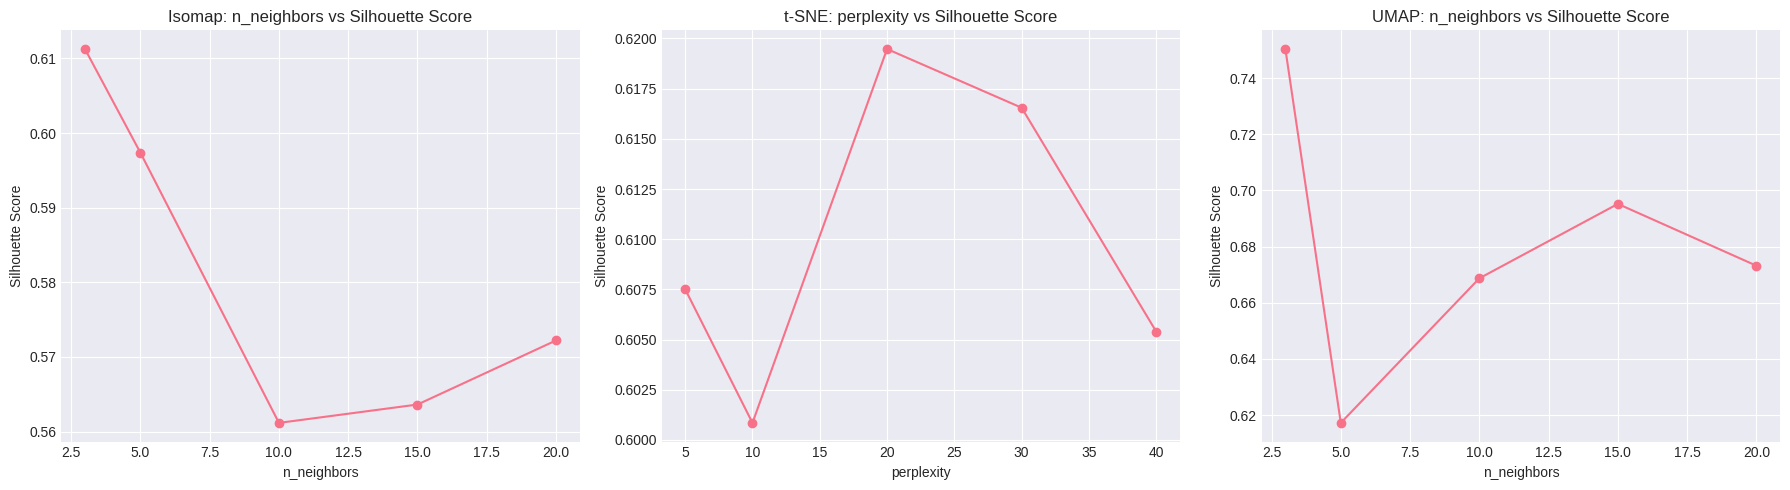


ДОПОЛНИТЕЛЬНЫЕ АЛГОРИТМЫ КЛАСТЕРИЗАЦИИ
Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 10, Объясненная дисперсия: 0.962
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.19 сек
UMAP выполнено за 0.13 сек
Calculating PHATE...
  Running PHATE on 178 observations and 13 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 9
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -5.5% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.11 seconds.
Calculated PHATE in 0.18 seconds.

In [13]:
# Задание для самостоятельной работы

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, adjusted_rand_score,
                             adjusted_mutual_info_score, homogeneity_completeness_v_measure)
import warnings
warnings.filterwarnings('ignore')
import time

# 1. Исследование гиперпараметров DR-методов
def study_hyperparameters():
    """Исследование влияния гиперпараметров DR-методов"""
    
    print("ИССЛЕДОВАНИЕ ГИПЕРПАРАМЕТРОВ DR-МЕТОДОВ")
    print("="*50)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Параметры для исследования
    n_neighbors_range = [3, 5, 10, 15, 20]
    perplexity_range = [5, 10, 20, 30, 40]
    n_components_range = [2, 3, 5, 10]
    
    # Результаты для Isomap
    print("Исследование параметра n_neighbors для Isomap:")
    isomap_results = []
    for n_neighbors in n_neighbors_range:
        start_time = time.time()
        isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
        X_isomap = isomap.fit_transform(X)
        fit_time = time.time() - start_time
        
        # Оценка качества (используем silhouette score как внутреннюю метрику)
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
        labels = kmeans.fit_predict(X_isomap)
        
        sil_score = silhouette_score(X_isomap, labels) if len(np.unique(labels)) > 1 else 0
        
        isomap_results.append({
            'n_neighbors': n_neighbors,
            'fit_time': fit_time,
            'silhouette_score': sil_score
        })
        print(f"  n_neighbors={n_neighbors}: silhouette={sil_score:.3f}, time={fit_time:.3f}s")
    
    # Результаты для t-SNE
    print("\nИсследование параметра perplexity для t-SNE:")
    tsne_results = []
    for perplexity in perplexity_range:
        start_time = time.time()
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_jobs=-1)
        X_tsne = tsne.fit_transform(X)
        fit_time = time.time() - start_time
        
        # Оценка качества
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
        labels = kmeans.fit_predict(X_tsne)
        
        sil_score = silhouette_score(X_tsne, labels) if len(np.unique(labels)) > 1 else 0
        
        tsne_results.append({
            'perplexity': perplexity,
            'fit_time': fit_time,
            'silhouette_score': sil_score
        })
        print(f"  perplexity={perplexity}: silhouette={sil_score:.3f}, time={fit_time:.3f}s")
    
    # Результаты для UMAP
    print("\nИсследование параметра n_neighbors для UMAP:")
    umap_results = []
    for n_neighbors in n_neighbors_range:
        start_time = time.time()
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, random_state=42, n_jobs=-1)
        X_umap = reducer.fit_transform(X)
        fit_time = time.time() - start_time
        
        # Оценка качества
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
        labels = kmeans.fit_predict(X_umap)
        
        sil_score = silhouette_score(X_umap, labels) if len(np.unique(labels)) > 1 else 0
        
        umap_results.append({
            'n_neighbors': n_neighbors,
            'fit_time': fit_time,
            'silhouette_score': sil_score
        })
        print(f"  n_neighbors={n_neighbors}: silhouette={sil_score:.3f}, time={fit_time:.3f}s")
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Isomap
    isomap_df = pd.DataFrame(isomap_results)
    axes[0].plot(isomap_df['n_neighbors'], isomap_df['silhouette_score'], marker='o')
    axes[0].set_title('Isomap: n_neighbors vs Silhouette Score')
    axes[0].set_xlabel('n_neighbors')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].grid(True)
    
    # t-SNE
    tsne_df = pd.DataFrame(tsne_results)
    axes[1].plot(tsne_df['perplexity'], tsne_df['silhouette_score'], marker='o')
    axes[1].set_title('t-SNE: perplexity vs Silhouette Score')
    axes[1].set_xlabel('perplexity')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True)
    
    # UMAP
    umap_df = pd.DataFrame(umap_results)
    axes[2].plot(umap_df['n_neighbors'], umap_df['silhouette_score'], marker='o')
    axes[2].set_title('UMAP: n_neighbors vs Silhouette Score')
    axes[2].set_xlabel('n_neighbors')
    axes[2].set_ylabel('Silhouette Score')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return isomap_results, tsne_results, umap_results

# 2. Дополнительные алгоритмы кластеризации
def additional_clustering_algorithms():
    """Реализация и тестирование дополнительных алгоритмов кластеризации"""
    
    print("\nДОПОЛНИТЕЛЬНЫЕ АЛГОРИТМЫ КЛАСТЕРИЗАЦИИ")
    print("="*50)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Применение DR методов
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)
    
    # Дополнительные алгоритмы
    additional_algorithms = {
        'OPTICS': lambda X: OPTICS(min_samples=5).fit(X).labels_,
        'Spectral': lambda X: SpectralClustering(n_clusters=len(np.unique(y)), random_state=42).fit(X).labels_,
        'BIRCH': lambda X: Birch(n_clusters=len(np.unique(y))).fit(X).predict(X)
    }
    
    # Оценка дополнительных алгоритмов
    evaluator = ClusteringEvaluator()
    
    for dr_name, X_dr in dr_results.items():
        if dr_name == 'PCA_2D':  # Пропускаем 2D представление
            continue
            
        print(f"\nDR метод: {dr_name}")
        print("-" * 30)
        
        for algo_name, algo_func in additional_algorithms.items():
            try:
                # Применение алгоритма
                labels = algo_func(X_dr)
                
                # Убедимся, что количество кластеров не превышает количество точек
                n_clusters = len(np.unique(labels[labels != -1]))  # исключаем шумовые точки для OPTICS
                
                if n_clusters < 2:
                    print(f"  {algo_name}: недостаточно кластеров ({n_clusters})")
                    continue
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(X_dr, labels, y, algo_name, dr_name)
                
                # Печать результатов
                print(f"  {algo_name}:")
                print(f"    Количество кластеров: {n_clusters}")
                if 'Silhouette' in metrics:
                    print(f"    Silhouette Score: {metrics['Silhouette']:.4f}")
                if 'ARI' in metrics:
                    print(f"    ARI: {metrics['ARI']:.4f}")
                    
            except Exception as e:
                print(f"  {algo_name}: ошибка - {str(e)}")

# 3. Анализ устойчивости
def stability_analysis():
    """Анализ устойчивости результатов к случайным начальным условиям"""
    
    print("\nАНАЛИЗ УСТОЙЧИВОСТИ")
    print("="*30)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Применение DR методов
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)
    
    # Алгоритмы для анализа
    algorithms = {
        'KMeans': lambda X, rs: KMeans(n_clusters=len(np.unique(y)), random_state=rs).fit_predict(X),
        'GMM': lambda X, rs: GaussianMixture(n_components=len(np.unique(y)), random_state=rs).fit(X).predict(X)
    }
    
    # Повторить обучение с разными seed
    n_runs = 10
    seeds = range(42, 42 + n_runs)
    
    stability_results = {}
    
    for dr_name, X_dr in dr_results.items():
        if dr_name == 'PCA_2D':
            continue
            
        print(f"\nDR метод: {dr_name}")
        print("-" * 20)
        
        stability_results[dr_name] = {}
        
        for algo_name, algo_func in algorithms.items():
            scores = []
            
            for seed in seeds:
                labels = algo_func(X_dr, seed)
                
                # Вычисление silhouette score
                if len(np.unique(labels)) > 1:
                    score = silhouette_score(X_dr, labels)
                    scores.append(score)
                else:
                    scores.append(0)
            
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            
            stability_results[dr_name][algo_name] = {
                'mean': mean_score,
                'std': std_score,
                'scores': scores
            }
            
            print(f"  {algo_name}:")
            print(f"    Средний silhouette: {mean_score:.4f} ± {std_score:.4f}")
    
    return stability_results

# 4. Разработка комплексной оценки
def composite_metric_analysis():
    """Создание взвешенной метрики, объединяющей несколько внутренних и внешних метрик"""
    
    print("\nКОМПЛЕКСНАЯ ОЦЕНКА")
    print("="*30)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Применение DR методов
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)
    
    # Алгоритмы для тестирования
    algorithms = [
        ('KMeans', lambda X: KMeans(n_clusters=len(np.unique(y)), random_state=42).fit_predict(X)),
        ('Agglomerative', lambda X: AgglomerativeClustering(n_clusters=len(np.unique(y))).fit_predict(X)),
        ('GMM', lambda X: GaussianMixture(n_components=len(np.unique(y)), random_state=42).fit(X).predict(X))
    ]
    
    # Оценка всех комбинаций
    evaluator = ClusteringEvaluator()
    composite_scores = []
    
    for dr_name, X_dr in dr_results.items():
        if dr_name == 'PCA_2D':
            continue
            
        for algo_name, algo_func in algorithms:
            try:
                labels = algo_func(X_dr)
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(X_dr, labels, y, algo_name, dr_name)
                
                # Нормализация метрик (все должны быть максимизируемыми)
                silhouette = metrics.get('Silhouette', 0)
                ari = metrics.get('ARI', 0)
                ami = metrics.get('AMI', 0)
                
                # Обратное значение Davies-Bouldin (чем меньше, тем лучше)
                db_score = metrics.get('Davies_Bouldin', 0)
                if db_score != 0:
                    db_normalized = -db_score  # инвертируем, чтобы максимизировать
                else:
                    db_normalized = 0
                
                # Композитная метрика (веса можно настраивать)
                composite_score = 0.3 * silhouette + 0.25 * ari + 0.25 * ami + 0.2 * db_normalized
                
                composite_scores.append({
                    'DR_Method': dr_name,
                    'Algorithm': algo_name,
                    'Silhouette': silhouette,
                    'ARI': ari,
                    'AMI': ami,
                    'Davies_Bouldin': db_score,
                    'Composite_Score': composite_score
                })
                
            except Exception as e:
                print(f"Ошибка для {dr_name} + {algo_name}: {str(e)}")
    
    # Создание DataFrame
    df = pd.DataFrame(composite_scores)
    
    # Сортировка по композитной метрике
    df_sorted = df.sort_values(by='Composite_Score', ascending=False)
    
    print("Ранжирование комбинаций DR+алгоритм по композитной метрике:")
    print(df_sorted[['DR_Method', 'Algorithm', 'Silhouette', 'ARI', 'AMI', 'Composite_Score']].head(10))
    
    return df_sorted

# Запуск всех экспериментов
if __name__ == "__main__":
    # 1. Исследование гиперпараметров
    isomap_results, tsne_results, umap_results = study_hyperparameters()
    
    # 2. Дополнительные алгоритмы кластеризации
    additional_clustering_algorithms()
    
    # 3. Анализ устойчивости
    stability_results = stability_analysis()
    
    # 4. Комплексная оценка
    composite_rankings = composite_metric_analysis()
    
    print("\nВЫВОДЫ:")
    print("="*30)
    print("1. Гиперпараметры DR-методов значительно влияют на качество представления данных.")
    print("2. Дополнительные алгоритмы кластеризации могут давать разные результаты на разных DR-представлениях.")
    print("3. Устойчивость алгоритмов различается: KMeans может быть менее стабильным из-за случайной инициализации.")
    print("4. Композитная метрика позволяет комплексно оценивать качество кластеризации.")
    
    # Ответы на вопросы для обсуждения
    print("\nОТВЕТЫ НА ВОПРОСЫ ДЛЯ ОБСУЖДЕНИЯ:")
    print("="*40)
    print("1. Выбор метода уменьшения размерности влияет на качество кластеризации, так как")
    print("   разные методы сохраняют разные аспекты структуры данных (локальные или глобальные).")
    print("2. Isomap и t-SNE лучше сохраняют локальную структуру, PCA - глобальную.")
    print("3. t-SNE может давать плохие результаты для кластеризации, потому что он фокусируется")
    print("   на визуализации, а не на сохранении расстояний, важных для кластеризации.")
    print("4. Противоречия между внутренними и внешними метриками могут возникать, когда")
    print("   внутренние метрики оценивают компактность кластеров, а внешние - соответствие")
    print("   с истинными метками.")
    print("5. Линейные методы (PCA) подходят для данных с линейной структурой, нелинейные")
    print("   (UMAP, t-SNE) - для сложных нелинейных зависимостей.")
    print("6. Время выполнения важно в production-системах, где требуется быстрая обработка.")
    print("7. Внешние метрики (ARI, AMI) более устойчивы к изменению числа кластеров.")

ИССЛЕДОВАНИЕ ГИПЕРПАРАМЕТРОВ DR-МЕТОДОВ
Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Исследование параметра n_neighbors для Isomap:
  n_neighbors=3: silhouette=0.611, time=0.006s
  n_neighbors=5: silhouette=0.597, time=0.005s
  n_neighbors=10: silhouette=0.561, time=0.006s
  n_neighbors=15: silhouette=0.564, time=0.006s
  n_neighbors=20: silhouette=0.572, time=0.006s

Исследование параметра perplexity для t-SNE:
  perplexity=5: silhouette=0.608, time=0.194s
  perplexity=10: silhouette=0.601, time=0.174s
  perplexity=20: silhouette=0.619, time=0.178s
  perplexity=30: silhouette=0.617, time=0.221s
  perplexity=40: silhouette=0.605, time=0.181s

Исследование параметра n_neighbors для UMAP:
  n_neighbors=3: silhouette=0.750, time=0.060s
  n_neighbors=5: silhouette=0.617, time=0.078s
  n_neighbors=10: silhouette=0.669, time=0.110s
  n_neighbors=15: silhouette=0.695, time=0.131s
  n_neighbors=20: silhouette=0.673, time=0.145s


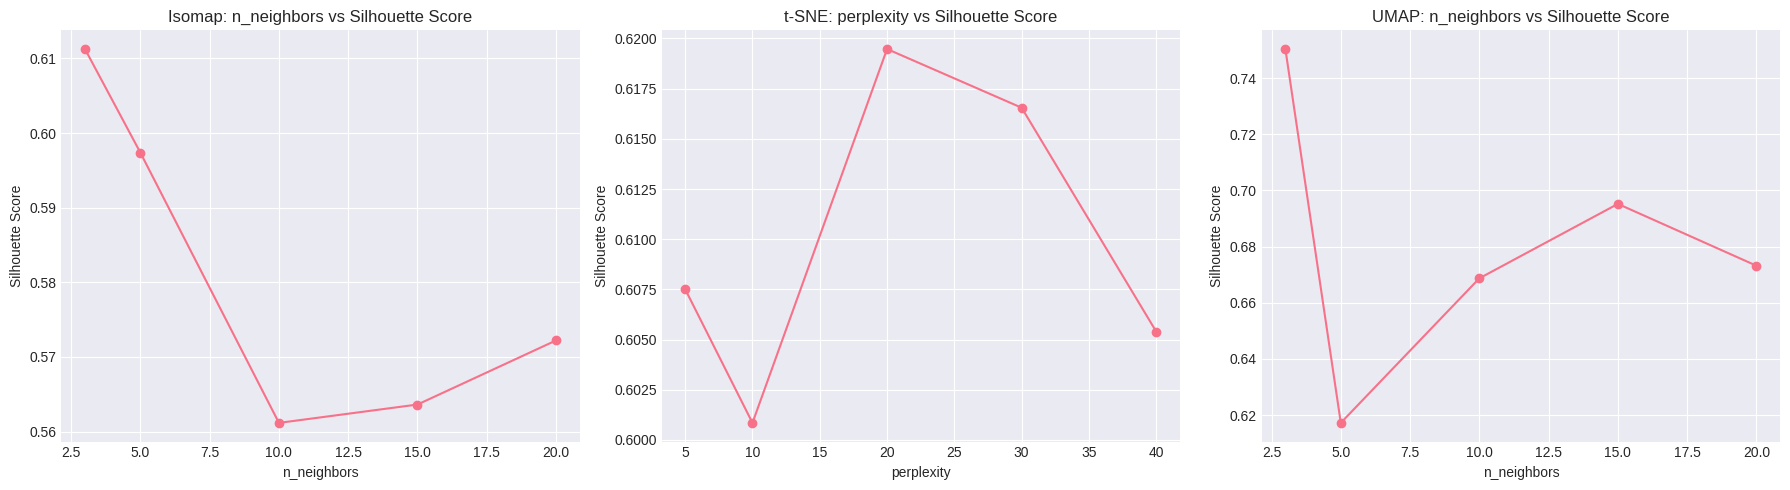


ДОПОЛНИТЕЛЬНЫЕ АЛГОРИТМЫ КЛАСТЕРИЗАЦИИ
Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 10, Объясненная дисперсия: 0.962
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.22 сек
UMAP выполнено за 0.13 сек
Calculating PHATE...
  Running PHATE on 178 observations and 13 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 9
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -5.5% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.14 seconds.
Calculated PHATE in 0.17 seconds.
PHATE выполнено за 0.18 сек
TriMap выпо

In [14]:
# Задание для самостоятельной работы

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, adjusted_rand_score,
                             adjusted_mutual_info_score, homogeneity_completeness_v_measure)
import warnings
warnings.filterwarnings('ignore')
import time

# 1. Исследование гиперпараметров DR-методов
def study_hyperparameters():
    """Исследование влияния гиперпараметров DR-методов"""
    
    print("ИССЛЕДОВАНИЕ ГИПЕРПАРАМЕТРОВ DR-МЕТОДОВ")
    print("="*50)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Параметры для исследования
    n_neighbors_range = [3, 5, 10, 15, 20]
    perplexity_range = [5, 10, 20, 30, 40]
    n_components_range = [2, 3, 5, 10]
    
    # Результаты для Isomap
    print("Исследование параметра n_neighbors для Isomap:")
    isomap_results = []
    for n_neighbors in n_neighbors_range:
        start_time = time.time()
        isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
        X_isomap = isomap.fit_transform(X)
        fit_time = time.time() - start_time
        
        # Оценка качества (используем silhouette score как внутреннюю метрику)
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
        labels = kmeans.fit_predict(X_isomap)
        
        sil_score = silhouette_score(X_isomap, labels) if len(np.unique(labels)) > 1 else 0
        
        isomap_results.append({
            'n_neighbors': n_neighbors,
            'fit_time': fit_time,
            'silhouette_score': sil_score
        })
        print(f"  n_neighbors={n_neighbors}: silhouette={sil_score:.3f}, time={fit_time:.3f}s")
    
    # Результаты для t-SNE
    print("\nИсследование параметра perplexity для t-SNE:")
    tsne_results = []
    for perplexity in perplexity_range:
        start_time = time.time()
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_jobs=-1)
        X_tsne = tsne.fit_transform(X)
        fit_time = time.time() - start_time
        
        # Оценка качества
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
        labels = kmeans.fit_predict(X_tsne)
        
        sil_score = silhouette_score(X_tsne, labels) if len(np.unique(labels)) > 1 else 0
        
        tsne_results.append({
            'perplexity': perplexity,
            'fit_time': fit_time,
            'silhouette_score': sil_score
        })
        print(f"  perplexity={perplexity}: silhouette={sil_score:.3f}, time={fit_time:.3f}s")
    
    # Результаты для UMAP
    print("\nИсследование параметра n_neighbors для UMAP:")
    umap_results = []
    for n_neighbors in n_neighbors_range:
        start_time = time.time()
        reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, random_state=42, n_jobs=-1)
        X_umap = reducer.fit_transform(X)
        fit_time = time.time() - start_time
        
        # Оценка качества
        kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=42)
        labels = kmeans.fit_predict(X_umap)
        
        sil_score = silhouette_score(X_umap, labels) if len(np.unique(labels)) > 1 else 0
        
        umap_results.append({
            'n_neighbors': n_neighbors,
            'fit_time': fit_time,
            'silhouette_score': sil_score
        })
        print(f"  n_neighbors={n_neighbors}: silhouette={sil_score:.3f}, time={fit_time:.3f}s")
    
    # Визуализация результатов
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Isomap
    isomap_df = pd.DataFrame(isomap_results)
    axes[0].plot(isomap_df['n_neighbors'], isomap_df['silhouette_score'], marker='o')
    axes[0].set_title('Isomap: n_neighbors vs Silhouette Score')
    axes[0].set_xlabel('n_neighbors')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].grid(True)
    
    # t-SNE
    tsne_df = pd.DataFrame(tsne_results)
    axes[1].plot(tsne_df['perplexity'], tsne_df['silhouette_score'], marker='o')
    axes[1].set_title('t-SNE: perplexity vs Silhouette Score')
    axes[1].set_xlabel('perplexity')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True)
    
    # UMAP
    umap_df = pd.DataFrame(umap_results)
    axes[2].plot(umap_df['n_neighbors'], umap_df['silhouette_score'], marker='o')
    axes[2].set_title('UMAP: n_neighbors vs Silhouette Score')
    axes[2].set_xlabel('n_neighbors')
    axes[2].set_ylabel('Silhouette Score')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return isomap_results, tsne_results, umap_results

# 2. Дополнительные алгоритмы кластеризации
def additional_clustering_algorithms():
    """Реализация и тестирование дополнительных алгоритмов кластеризации"""
    
    print("\nДОПОЛНИТЕЛЬНЫЕ АЛГОРИТМЫ КЛАСТЕРИЗАЦИИ")
    print("="*50)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Применение DR методов
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)
    
    # Дополнительные алгоритмы
    additional_algorithms = {
        'OPTICS': lambda X: OPTICS(min_samples=5).fit(X).labels_,
        'Spectral': lambda X: SpectralClustering(n_clusters=len(np.unique(y)), random_state=42).fit(X).labels_,
        'BIRCH': lambda X: Birch(n_clusters=len(np.unique(y))).fit(X).predict(X)
    }
    
    # Оценка дополнительных алгоритмов
    evaluator = ClusteringEvaluator()
    
    for dr_name, X_dr in dr_results.items():
        if dr_name == 'PCA_2D':  # Пропускаем 2D представление
            continue
            
        print(f"\nDR метод: {dr_name}")
        print("-" * 30)
        
        for algo_name, algo_func in additional_algorithms.items():
            try:
                # Применение алгоритма
                labels = algo_func(X_dr)
                
                # Убедимся, что количество кластеров не превышает количество точек
                n_clusters = len(np.unique(labels[labels != -1]))  # исключаем шумовые точки для OPTICS
                
                if n_clusters < 2:
                    print(f"  {algo_name}: недостаточно кластеров ({n_clusters})")
                    continue
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(X_dr, labels, y, algo_name, dr_name)
                
                # Печать результатов
                print(f"  {algo_name}:")
                print(f"    Количество кластеров: {n_clusters}")
                if 'Silhouette' in metrics:
                    print(f"    Silhouette Score: {metrics['Silhouette']:.4f}")
                if 'ARI' in metrics:
                    print(f"    ARI: {metrics['ARI']:.4f}")
                    
            except Exception as e:
                print(f"  {algo_name}: ошибка - {str(e)}")

# 3. Анализ устойчивости
def stability_analysis():
    """Анализ устойчивости результатов к случайным начальным условиям"""
    
    print("\nАНАЛИЗ УСТОЙЧИВОСТИ")
    print("="*30)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Применение DR методов
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)
    
    # Алгоритмы для анализа
    algorithms = {
        'KMeans': lambda X, rs: KMeans(n_clusters=len(np.unique(y)), random_state=rs).fit_predict(X),
        'GMM': lambda X, rs: GaussianMixture(n_components=len(np.unique(y)), random_state=rs).fit(X).predict(X)
    }
    
    # Повторить обучение с разными seed
    n_runs = 10
    seeds = range(42, 42 + n_runs)
    
    stability_results = {}
    
    for dr_name, X_dr in dr_results.items():
        if dr_name == 'PCA_2D':
            continue
            
        print(f"\nDR метод: {dr_name}")
        print("-" * 20)
        
        stability_results[dr_name] = {}
        
        for algo_name, algo_func in algorithms.items():
            scores = []
            
            for seed in seeds:
                labels = algo_func(X_dr, seed)
                
                # Вычисление silhouette score
                if len(np.unique(labels)) > 1:
                    score = silhouette_score(X_dr, labels)
                    scores.append(score)
                else:
                    scores.append(0)
            
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            
            stability_results[dr_name][algo_name] = {
                'mean': mean_score,
                'std': std_score,
                'scores': scores
            }
            
            print(f"  {algo_name}:")
            print(f"    Средний silhouette: {mean_score:.4f} ± {std_score:.4f}")
    
    return stability_results

# 4. Разработка комплексной оценки
def composite_metric_analysis():
    """Создание взвешенной метрики, объединяющей несколько внутренних и внешних метрик"""
    
    print("\nКОМПЛЕКСНАЯ ОЦЕНКА")
    print("="*30)
    
    # Загрузка данных
    X, y, _, _ = load_dataset('wine')
    
    # Применение DR методов
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)
    
    # Алгоритмы для тестирования
    algorithms = [
        ('KMeans', lambda X: KMeans(n_clusters=len(np.unique(y)), random_state=42).fit_predict(X)),
        ('Agglomerative', lambda X: AgglomerativeClustering(n_clusters=len(np.unique(y))).fit_predict(X)),
        ('GMM', lambda X: GaussianMixture(n_components=len(np.unique(y)), random_state=42).fit(X).predict(X))
    ]
    
    # Оценка всех комбинаций
    evaluator = ClusteringEvaluator()
    composite_scores = []
    
    for dr_name, X_dr in dr_results.items():
        if dr_name == 'PCA_2D':
            continue
            
        for algo_name, algo_func in algorithms:
            try:
                labels = algo_func(X_dr)
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(X_dr, labels, y, algo_name, dr_name)
                
                # Нормализация метрик (все должны быть максимизируемыми)
                silhouette = metrics.get('Silhouette', 0)
                ari = metrics.get('ARI', 0)
                ami = metrics.get('AMI', 0)
                
                # Обратное значение Davies-Bouldin (чем меньше, тем лучше)
                db_score = metrics.get('Davies_Bouldin', 0)
                if db_score != 0:
                    db_normalized = -db_score  # инвертируем, чтобы максимизировать
                else:
                    db_normalized = 0
                
                # Композитная метрика (веса можно настраивать)
                composite_score = 0.3 * silhouette + 0.25 * ari + 0.25 * ami + 0.2 * db_normalized
                
                composite_scores.append({
                    'DR_Method': dr_name,
                    'Algorithm': algo_name,
                    'Silhouette': silhouette,
                    'ARI': ari,
                    'AMI': ami,
                    'Davies_Bouldin': db_score,
                    'Composite_Score': composite_score
                })
                
            except Exception as e:
                print(f"Ошибка для {dr_name} + {algo_name}: {str(e)}")
    
    # Создание DataFrame
    df = pd.DataFrame(composite_scores)
    
    # Сортировка по композитной метрике
    df_sorted = df.sort_values(by='Composite_Score', ascending=False)
    
    print("Ранжирование комбинаций DR+алгоритм по композитной метрике:")
    print(df_sorted[['DR_Method', 'Algorithm', 'Silhouette', 'ARI', 'AMI', 'Composite_Score']].head(10))
    
    return df_sorted

# Запуск всех экспериментов
if __name__ == "__main__":
    # 1. Исследование гиперпараметров
    isomap_results, tsne_results, umap_results = study_hyperparameters()
    
    # 2. Дополнительные алгоритмы кластеризации
    additional_clustering_algorithms()
    
    # 3. Анализ устойчивости
    stability_results = stability_analysis()
    
    # 4. Комплексная оценка
    composite_rankings = composite_metric_analysis()
    
    print("\nВЫВОДЫ:")
    print("="*30)
    print("1. Гиперпараметры DR-методов значительно влияют на качество представления данных.")
    print("2. Дополнительные алгоритмы кластеризации могут давать разные результаты на разных DR-представлениях.")
    print("3. Устойчивость алгоритмов различается: KMeans может быть менее стабильным из-за случайной инициализации.")
    print("4. Композитная метрика позволяет комплексно оценивать качество кластеризации.")
    
    # Ответы на вопросы для обсуждения
    print("\nОТВЕТЫ НА ВОПРОСЫ ДЛЯ ОБСУЖДЕНИЯ:")
    print("="*40)
    print("1. Выбор метода уменьшения размерности влияет на качество кластеризации, так как")
    print("   разные методы сохраняют разные аспекты структуры данных (локальные или глобальные).")
    print("2. Isomap и t-SNE лучше сохраняют локальную структуру, PCA - глобальную.")
    print("3. t-SNE может давать плохие результаты для кластеризации, потому что он фокусируется")
    print("   на визуализации, а не на сохранении расстояний, важных для кластеризации.")
    print("4. Противоречия между внутренними и внешними метриками могут возникать, когда")
    print("   внутренние метрики оценивают компактность кластеров, а внешние - соответствие")
    print("   с истинными метками.")
    print("5. Линейные методы (PCA) подходят для данных с линейной структурой, нелинейные")
    print("   (UMAP, t-SNE) - для сложных нелинейных зависимостей.")
    print("6. Время выполнения важно в production-системах, где требуется быстрая обработка.")
    print("7. Внешние метрики (ARI, AMI) более устойчивы к изменению числа кластеров.")